In [1]:
import os
import pandas as pd
import numpy as np
import random
import itertools
import timeit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download Data from OpenML https://www.openml.org/d/37
df_diabetes = pd.read_csv('pima_diabetes.csv')
print("Diabetes shape: ",df_diabetes.shape)

# Download Data from OpenML https://www.openml.org/d/37
df_wine_data = pd.read_csv('wine-quality-red.csv')
print("Wine data shape: ",df_wine_data.shape)

Diabetes shape:  (768, 9)
Wine data shape:  (1599, 12)


In [4]:
# For diabetes data
diabetes_map = {'tested_positive' : 1, 'tested_negative' : 0}
df_diabetes['class'] = df_diabetes['class'].map(diabetes_map)

# For wine data
def quality(q):
    if q == 3:
        return 0
    elif q == 4:
        return 1
    elif q == 5:
        return 2
    elif q == 6:
        return 3
    elif q == 7:
        return 4
    else:
        return 5

df_wine_data['class'] = df_wine_data['class'].apply(quality)

In [5]:
df_diabetes.head(5)

preg  plas  pres  skin  insu  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1

In [6]:
df_wine_data.head(5)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  class  
0      9.4      2  
1      9.8      2  
2      9.8      2  
3      9.8      3  
4      9.4      2

In [7]:
diabetes_percent = df_diabetes['class'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
wine_percent = df_wine_data['class'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print("Diabetes class distribution:")
print(diabetes_percent)
print(30*"-")

Diabetes class distribution:
0    65.1%
1    34.9%
Name: class, dtype: object
------------------------------


class    1.000000
plas     0.466581
mass     0.292695
age      0.238356
preg     0.221898
pedi     0.173844
insu     0.130548
skin     0.074752
pres     0.065068
Name: class, dtype: float64

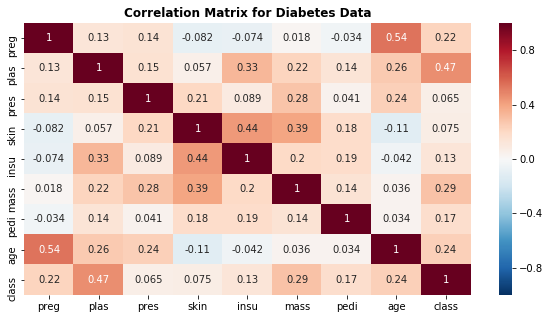

In [8]:
# Correlation between the target variable and predictor variables
correlation2 = df_diabetes.corr()
plt.figure(figsize=(10, 5))
plt.title("Correlation Matrix for Diabetes Data", fontsize=12, fontweight='bold')
sns.heatmap(correlation2, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
fname = 'Correlation_Diabetes.jpg'
plt.savefig(fname)

correlation2['class'].sort_values(ascending=False)

# Helper functions

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neural_network import MLPClassifier
from scipy.stats import mode

def import_data():
    X1 = StandardScaler().fit_transform(np.array(df_diabetes.iloc[:,:-1].values))
    Y1 = np.array(df_diabetes.iloc[:,-1].values)
    X2 = StandardScaler().fit_transform(np.array(df_wine_data.iloc[:,:-1].values))
    Y2 = np.array(df_wine_data.iloc[:,-1].values)
    return X1,Y1,X2,Y2

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        pred[mask] = mode(Y[mask])[0]
    '''pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)  '''  
    return pred

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [10]:
X1,Y1,X2,Y2=import_data()
print(X1.shape)

(768, 8)


In [11]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(np.array(X1),np.array(Y1), test_size=0.20, random_state = 0)
clf = DummyClassifier(strategy='most_frequent', random_state=20)
clf.fit(X1_train, Y1_train)
print(clf.score(X1_test, Y1_test))

0.6948051948051948


In [12]:
# K Means clustering and EM
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, homogeneity_score, completeness_score, silhouette_samples, v_measure_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [146]:
#Kmeans Selection of k

def run_kmeans(X,y,title, n = 30, file=''):

    kclusters = list(np.arange(2,n))
    sil_scores = []; c_scores = []; homo_scores = []; train_times = []
    Sum_of_squared_distances = []; v_scores =[]

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=20,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        kc_labels = km.predict(X)
        sil_scores.append(sil_score(X, kc_labels))
        c_scores.append(completeness_score(y, kc_labels))
        homo_scores.append(homogeneity_score(y, kc_labels))
        v_scores.append(v_measure_score(y, kc_labels))
        Sum_of_squared_distances.append(km.inertia_)
        
        
    # curve for silhouette score
    print(v_scores)
    fig = plt.figure()
    fig.set_size_inches(6, 4)
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Silhoutte vs No. of clusters')
    fname = 'Sil_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    
   
    # plot scores    
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kclusters, homo_scores, color="r", label="Homogeneity Scores")
    ax.plot(kclusters, c_scores, color="g", label="Completeness Scores")
    plt.grid(True)
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title('Scores vs number of clusters')
    plt.legend(loc="best")
    fname = 'Score_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    
    
    # plot scores    
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    plt.plot(kclusters, Sum_of_squared_distances)
    plt.grid(True)
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    fname = 'SS_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()

def evaluate_kmeans(km, X, y, title=''):
    start_time = timeit.default_timer()
    km.fit(X)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)    
    accuracy = accuracy_score(y, y_mode_vote)
    
    print("Model Evaluation Metrics Using Mode Cluster Vote: "+title)
    print("***********************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))      
    print("V Measure Score: {:.2f}".format(v_measure_score(y, km.labels_))) 
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("***********************************************************")
    plt.figure()
    plt.show()

[0.062228529808886685, 0.08905729097408221, 0.10652589167492343, 0.07898466276963016, 0.07173159569246298, 0.06822068814238495, 0.0693197886594788]


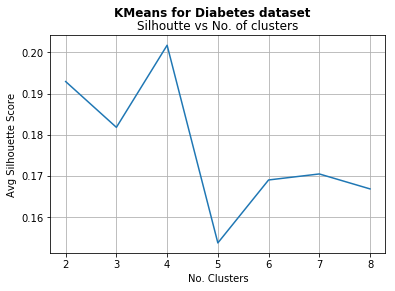

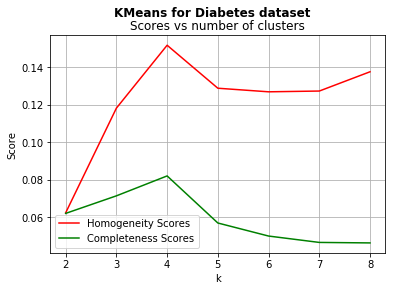

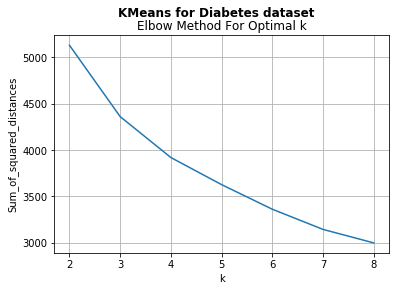

In [147]:
run_kmeans(X1,Y1,title='KMeans for Diabetes dataset', n=9, file = "Km_D")

In [148]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', 
            verbose=0, random_state=20, copy_x=True, n_jobs=-1, algorithm='auto')
evaluate_kmeans(km,X1,Y1, title ="Kmeans-Diabetes")
km.fit(X1) # [:,np.newaxis] converts data from 1D to 2D
'''res=km.__dict__
result = res['cluster_centers_']
df= pd.DataFrame(result, columns = df_diabetes.columns[:-1], index = range(4))
df'''

Model Evaluation Metrics Using Mode Cluster Vote: Kmeans-Diabetes
***********************************************************
Model Training Time (s):   0.05
No. Iterations to Converge: 49
V Measure Score: 0.11
Accuracy:  0.70
***********************************************************


<Figure size 432x288 with 0 Axes>

"res=km.__dict__\nresult = res['cluster_centers_']\ndf= pd.DataFrame(result, columns = df_diabetes.columns[:-1], index = range(4))\ndf"

## PCA, ICA, RCA, RCF

In [16]:
# PCA
from sklearn.decomposition import PCA, FastICA as FICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import LinearSVC
from sklearn import metrics
from itertools import product
from collections import defaultdict
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import SelectFromModel


def run_PCA(x,y,title='',file=""):
    
    pca = PCA(random_state=20).fit(x) #for all components
    print(pca.explained_variance_)
    '''n_samples = x.shape[0]
    X_centered = x - np.mean(x, axis=0)
    cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
    eigenvalues=(pca.explained_variance_)
    for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
        print("Eigen vector:\n",np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
        print("Eigenvalues:\n",eigenvalue)'''
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(cum_var))), cum_var, 'g-', label='cumulative variance ratio')
    ax1.set_xlabel('Principal Components')    
    ax1.set_ylabel('Cumulative Explained Variance', color='g')
    ax1.tick_params('y', colors='g')
    plt.legend(loc="lower left")
    plt.grid(False)
    plt.axhline(y = .90, color='b', linestyle='--', label = '90% Explained Variance')
    #plt.axhline(y = .85, color='c', linestyle='--', label = '95% Explained Variance')

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'r-',label='Singular values')
    ax2.set_ylabel('Singular values', color='r')
    ax2.tick_params('y', colors='r')
    plt.grid(False)

    plt.title("PCA Explained Variance and Singular values: "+ title)
    fig.tight_layout()
    plt.legend(loc="lower right")
    fname = 'PCA_Variance'+file+'.jpg'
    plt.savefig(fname)
    plt.show()   
    
    
def run_ICA(x,y,title='',file=""):
        dims = list(np.arange(2,(x.shape[1]),1))
        print(dims)
        ica = FICA(random_state=20)
       
        kurt = []
        dims1=2

        tmp2 = ica.fit_transform(x)
        tmp2 = pd.DataFrame(tmp2)
        print(tmp2.head(20))
        #print(tmp2.kurt())
        tmp2.plot(rot=0,subplots=True,figsize=(20,20))
        #plt.figure()
        #tmp2.plot();
        plt.show()
        """
        for dim in dims:
            ica1 = FICA(random_state=20,n_components=dim)
            tmp1 = ica1.fit(x)
            print(tmp1.mixing_)
            print("Line")
        """ 

        for dim in dims:
            ica.set_params(n_components=dim)
            tmp = ica.fit_transform(x)

            tmp = pd.DataFrame(tmp)

            tmp = tmp.kurt(axis=0)
            #print(tmp.components_)
            kurt.append(tmp.abs().mean())

        plt.figure()
        plt.title("ICA Kurtosis: "+ title)
        plt.xlabel("Number of Independent Components")
        plt.ylabel("Avg Kurtosis Across IC")
        plt.plot(dims, kurt, 'b-')
        plt.grid(False)
        fname = 'ICA_Kurtosis'+file+'.jpg'
        plt.savefig(fname)
        plt.show()

def run_RCA(x,y,title='Pima indians dataset',file=''):    
    dims = list(np.arange(1,(x.shape[1]),1))
    tmp = defaultdict(dict)
    tt = []
    xtrain,xtest, ytrain, ytest = train_test_split(np.array(x),np.array(y), test_size=0.20, random_state =0)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)        
        d1 = pairwise_distances(rp.fit_transform(x))
        d2 = pairwise_distances(x)
        #d3 = pairwise_distances(d1,d2)
        coef = np.corrcoef(d1.ravel(),d2.ravel())[0,1]    
        tmp[dim][i] = coef
         
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()
    
    for dim in dims:
        rp = RCA(random_state=20, n_components=dim)
        model = LinearSVC(random_state=20)
        model.fit(rp.fit_transform(xtrain), ytrain)
        test = rp.transform(xtest)
        tt.append(metrics.accuracy_score(model.predict(test), ytest))
        
    fig, ax1 = plt.subplots()
    #ax1.plot(dims,tt, 'b-', label='Accuracy', color='b', linestyle='--') 
    ax1.plot(dims,mean_recon, 'g-', label='Mean Reconstruction Correlation')
    ax1.set_xlabel('Random Components')
    ax1.set_ylabel('Mean Reconstruction Correlation', color='g')
    ax1.tick_params('y', colors='g')
    ax1.legend(loc="best")
    plt.grid(False)
   
    ax2 = ax1.twinx()
    #ax2.plot(dims,std_recon, 'r-', label='STD Reconstruction Correlation')
    #ax2.set_ylabel('STD Reconstruction Correlation', color='r')
    ax2.plot(dims,tt, 'r-', label='Accuracy', color='r')    
    ax2.set_ylabel('Accuracy Score', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc="best")
    plt.grid(False)

    plt.title("Mean reconstruction correlation/accuracy of components "+ title)
    plt.legend(loc="best")
    fig.tight_layout()
    fname = 'RCA_Mean'+file+'.jpg'
    plt.savefig(fname)    
    plt.show()
    
def run_RFC(x,y,df_original,title='',file=""):
    rfc = RFC(n_estimators=100,min_samples_leaf=round(len(x)*.01),random_state=20,n_jobs=-1)
    rfc.fit(x,y)
    imp = rfc.feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[:-1])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.90]
    selected_cols = imp.index.tolist()
    important_features = rfc.feature_importances_ 
    indices = np.argsort(important_features)[::-1]
    df_original.columns[:-1]
    plt.bar(indices, important_features[indices])
    plt.xticks(range(x.shape[1]), df_original.columns[:-1], rotation =90)    
    plt.xlabel('feature index')
    plt.ylabel('importance value')
    plt.title('RFC importance: '+title)
    fname = 'RFC_features'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    print('imp ', imp)
    print('selected_cols ', selected_cols)
    return imp, selected_cols

# Clusters visualization after PCA in k means

In [77]:
def run_PCA_Kmeans(x,y,zipval,k,title):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    pca = PCA(5)#.fit(x) #for all components
    principalComponents = pca.fit_transform(X_std)
    
    # Save components to a DataFrame
    PCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k) #kmeans for diabetes
   #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,0],principalComponents[:,1], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

    
    #figure(4)
    #https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com
    #print(x[0])
    nComp = 3
    Xhat = np.dot(pca.transform(x)[:,:nComp], pca.components_[:nComp,:])
    mu = np.mean(x, axis=0)
    Xhat += mu
    #print(Xhat[0])

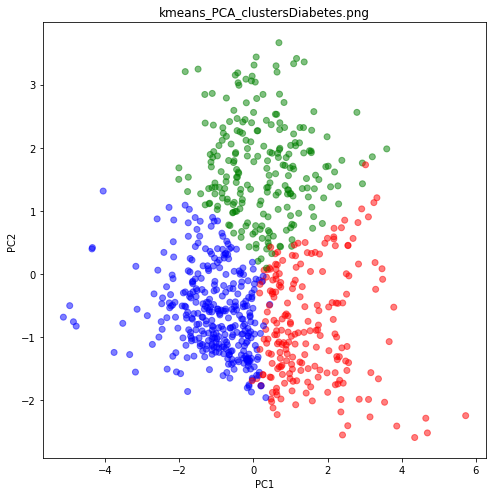

In [78]:
run_PCA_Kmeans(X1,Y1,(0,1),3,title='kmeans_PCA_clustersDiabetes.png')

In [86]:
def run_ICA_Kmeans(x,y,zipval,k,title):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    ica = FICA(n_components = 7,random_state=20)#.fit(x) #for all components
    principalComponents = ica.fit_transform(X_std)
    
    # Save components to a DataFrame
    ICA_components = pd.DataFrame(principalComponents)
    
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k) #kmeans for diabetes
   #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,0],principalComponents[:,4], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('IC1')
    plt.ylabel('IC5')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()


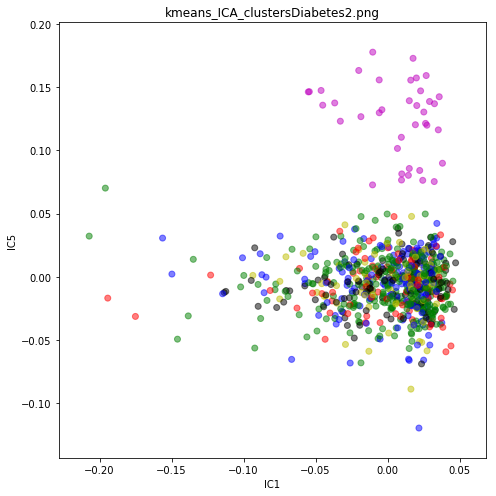

In [87]:
run_ICA_Kmeans(X1,Y1,(0,1),6,title='kmeans_ICA_clustersDiabetes2.png')

In [88]:
def run_RCA_Kmeans(x,y,zipval,k,title,d):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rca = RCA(random_state=20,n_components=d)#.fit(x) #for all components
    principalComponents = rca.fit_transform(X_std)
    
    # Save components to a DataFrame
    RCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k) #kmeans for diabetes
   #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,2],principalComponents[:,4], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('RC3')
    plt.ylabel('RC5')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()


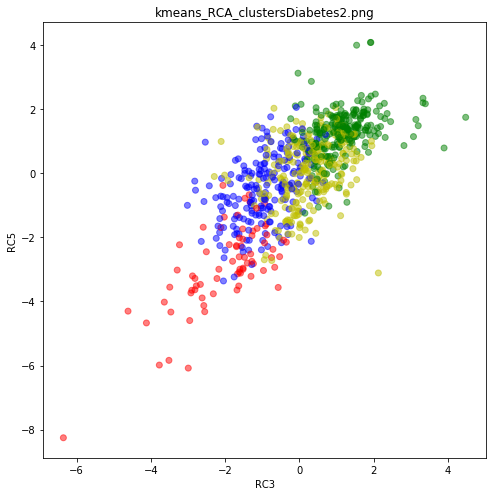

In [89]:
run_RCA_Kmeans(X1,Y1,(0,1),4,'kmeans_RCA_clustersDiabetes2.png',5)

In [106]:
def run_RFC_Kmeans(x,y,zipval,k,title,d):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rfc = RFC(n_estimators=100,min_samples_leaf=round(len(x)*.01),random_state=20,n_jobs=-1)
    fitdata=rfc.fit(x,y)
    #print(fitdata.get_params)
    best_features=rfc.feature_importances_
    print(best_features)
    bestFeature=np.argmax(best_features)
    # Save components to a DataFrame
    #RFC_components = pd.Dataframe(principalComponents)
    features_req=d
    topF=[]
    sorted_features=np.copy(best_features)
    sorted_features.sort()#sorting array
    sorted_features=sorted_features[::-1]#making it descending
    for i in range(features_req):
        topF.append(best_features.tolist().index(sorted_features[i]))
    newX = x[:,topF]
    newX=pd.DataFrame(newX)
        
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)#kmeans for diabetes
    #learner = KMeans(rfc)
    #Compute cluster centers and predict cluster indices
    X_clustered = kmeans.fit_predict(newX)
    #print(X_clustered)
    #accuracy = accuracy_score(y,X_clustered)
    #print("Accuracy:  "+"{:.2f}".format(accuracy))
    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    #print(topF)
    plt.figure(figsize = (6,4))
    plt.scatter(x[:,topF[0]],x[:,topF[1]], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('plas')
    plt.ylabel('mass')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

[0.06901305 0.35322223 0.0527326  0.05133484 0.0559482  0.17517483
 0.09650287 0.14607138]


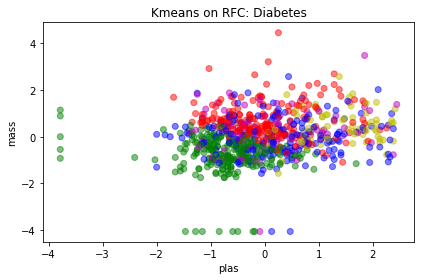

In [113]:
run_RFC_Kmeans(X1,Y1,(0,1),5,'Kmeans on RFC: Diabetes',6)

## PCA in EM

In [149]:
def run_PCA_EM(x,y,zipval,k,title):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    pca = PCA(5)#.fit(x) #for all components
    principalComponents = pca.fit_transform(X_std)
    
    # Save components to a DataFrame
    PCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a em instance 
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,0],principalComponents[:,1], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

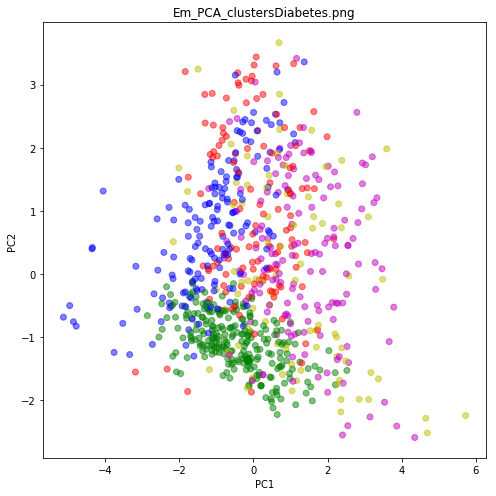

In [150]:
run_PCA_EM(X1,Y1,(0,1),5,title='Em_PCA_clustersDiabetes.png')

In [159]:
def run_ICA_EM(x,y,zipval,k,title):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    ica = FICA(n_components = 7,random_state=20)#.fit(x) #for all components
    principalComponents = ica.fit_transform(X_std)
    
    # Save components to a DataFrame
    ICA_components = pd.DataFrame(principalComponents)
    
        
    # Create a em instance 
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,0],principalComponents[:,4], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('IC1')
    plt.ylabel('IC5')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

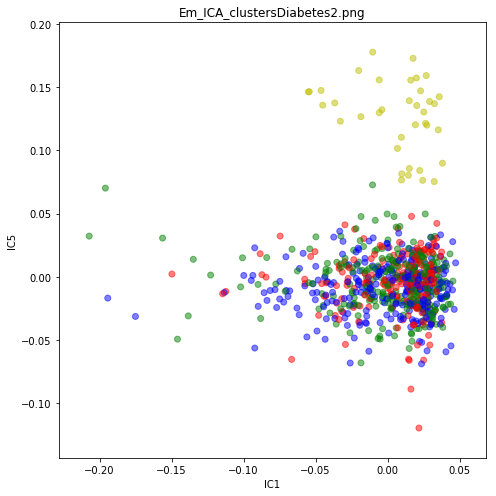

In [160]:
run_ICA_EM(X1,Y1,(0,1),4,title='Em_ICA_clustersDiabetes2.png')

In [161]:
def run_RCA_EM(x,y,zipval,k,title,d):
   

    #testing figures for pca only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rca = RCA(random_state=20,n_components=d)#.fit(x) #for all components
    principalComponents = rca.fit_transform(X_std)
    # Save components to a DataFrame
    RCA_components = pd.DataFrame(principalComponents)
    
        
    # Create a em instance 
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(principalComponents)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(principalComponents[:,2],principalComponents[:,4], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('RP3')
    plt.ylabel('RP5')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

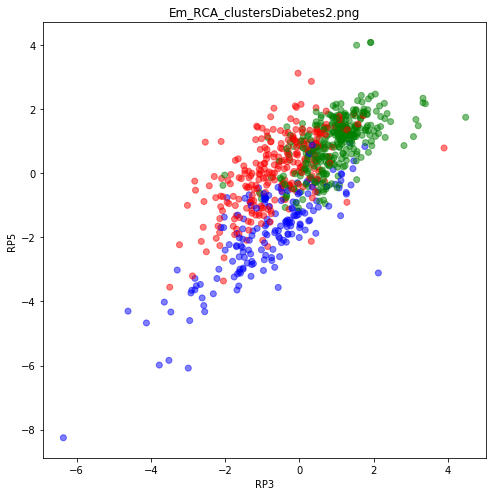

In [162]:
run_RCA_EM(X1,Y1,(0,1),3,'Em_RCA_clustersDiabetes2.png',5)

In [110]:
def run_RFC_EM(x,y,zipval,k,title,d):
   

    #testing figures for ica only
    # Plot the explained variances
    X_std = StandardScaler().fit_transform(x)
    rfc = RFC(n_estimators=100,min_samples_leaf=round(len(x)*.01),random_state=20,n_jobs=-1)
    fitdata=rfc.fit(x,y)
    #print(fitdata.get_params)
    best_features=rfc.feature_importances_
    print(best_features)
    bestFeature=np.argmax(best_features)
    # Save components to a DataFrame
    #RFC_components = pd.Dataframe(principalComponents)
    features_req=d
    topF=[]
    sorted_features=np.copy(best_features)
    sorted_features.sort()#sorting array
    sorted_features=sorted_features[::-1]#making it descending
    for i in range(features_req):
        topF.append(best_features.tolist().index(sorted_features[i]))
    newX = x[:,topF]
    newX=pd.DataFrame(newX)
        
    em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    X_clustered = em.fit_predict(newX)

    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b',3:'y',4:'m',5:'k'}#{0:'r', 1: 'g', 2: 'b',3:}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    #print(topF)
    plt.figure(figsize = (6,4))
    plt.scatter(x[:,topF[0]],x[:,topF[1]], c= label_color, alpha=0.5) #taking pca 1 and 2
    plt.xlabel('plas')
    plt.ylabel('mass')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

[0.06901305 0.35322223 0.0527326  0.05133484 0.0559482  0.17517483
 0.09650287 0.14607138]


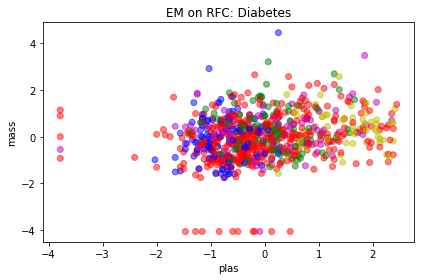

In [112]:
run_RFC_EM(X1,Y1,(0,1),5,'EM on RFC: Diabetes',6)

# Cluster vizualization with features for K means

In [34]:
def plotClustersHistogram(x,y,k1,dataset):
    random_seed = 7641
    kmeans=KMeans(n_clusters=k1,random_state=random_seed, max_iter=300, n_jobs=-1)
    kmeans.fit(x)
    plt.figure()
   #Store the labels
    labels = kmeans.labels_

    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print(counts)
    #Output : [243 244 245]
    #print(kmeans.labels_)
    plt.hist(kmeans.labels_, bins=np.arange(0, k1 + 1) - 0.5, rwidth=0.5, zorder=2)
    plt.xticks(np.arange(0, k1))
    plt.xlabel('Cluster label')
    plt.ylabel('Number of samples')
    plt.title(dataset)
    plt.grid()
    name='kmeans_hist_'+dataset+'.png'
    plt.savefig(name)
    
def plotClustersDiabetes(x,y):
    #for diabetes

    k1=4
    df1 = pd.read_csv('pima_diabetes.csv', nrows=1)
    to_drop = ['class']
    df1 = df1.drop(to_drop, axis=1)
    cols1 = df1.columns
    random_seed = 7641
    kmeans=KMeans(n_clusters=k1,random_state=random_seed, max_iter=300, n_jobs=-1)
    kmeans.fit(x)
    df1 = pd.DataFrame(x, columns = cols1)
    df1['result'] = y
    df1['class'] = kmeans.labels_
    print(df1.head(5))

    # Parallel coordinates plot
    rand_idx1 = np.arange(0,8,1)#all features
    idx_viz1 = np.append(rand_idx1, [df1.shape[1] - 2, df1.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df1.iloc[:, idx_viz1], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Diabetes: k-means visualization')
    plt.tight_layout()
    plt.savefig('kmeans_viz_1.png')
    

def plotClustersWine(x,y):
      
    #for wine data
    k1=6
    df2 = pd.read_csv('wine-quality-red.csv', nrows=1)
    to_drop = ['class']
    df2 = df2.drop(to_drop, axis=1)
    cols2 = df2.columns
    random_seed = 7641
    kmeans2=KMeans(n_clusters=k1,random_state=random_seed, max_iter=300, n_jobs=-1)
    kmeans2.fit(x)
    df2 = pd.DataFrame(x, columns = cols2)
    df2['result'] = y
    df2['class'] = kmeans2.labels_
    print(df2.head(5))

    # Parallel coordinates plot
    rand_idx2 = np.arange(0,11,1)#all 11 features
    #print(rand_idx2)
    idx_viz2 = np.append(rand_idx2, [df2.shape[1] - 2, df2.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df2.iloc[:, idx_viz2], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Wines: k-means visualization')
    plt.tight_layout()
    plt.savefig('kmeans_viz_2.png')
    

       preg      plas      pres      skin      insu      mass      pedi  \
0  0.639947  0.848324  0.149641  0.907270 -0.692891  0.204013  0.468492   
1 -0.844885 -1.123396 -0.160546  0.530902 -0.692891 -0.684422 -0.365061   
2  1.233880  1.943724 -0.263941 -1.288212 -0.692891 -1.103255  0.604397   
3 -0.844885 -0.998208 -0.160546  0.154533  0.123302 -0.494043 -0.920763   
4 -1.141852  0.504055 -1.504687  0.907270  0.765836  1.409746  5.484909   

        age  result  class  
0  1.425995       1      0  
1 -0.190672       0      1  
2 -0.105584       1      0  
3 -1.041549       0      1  
4 -0.020496       1      3  


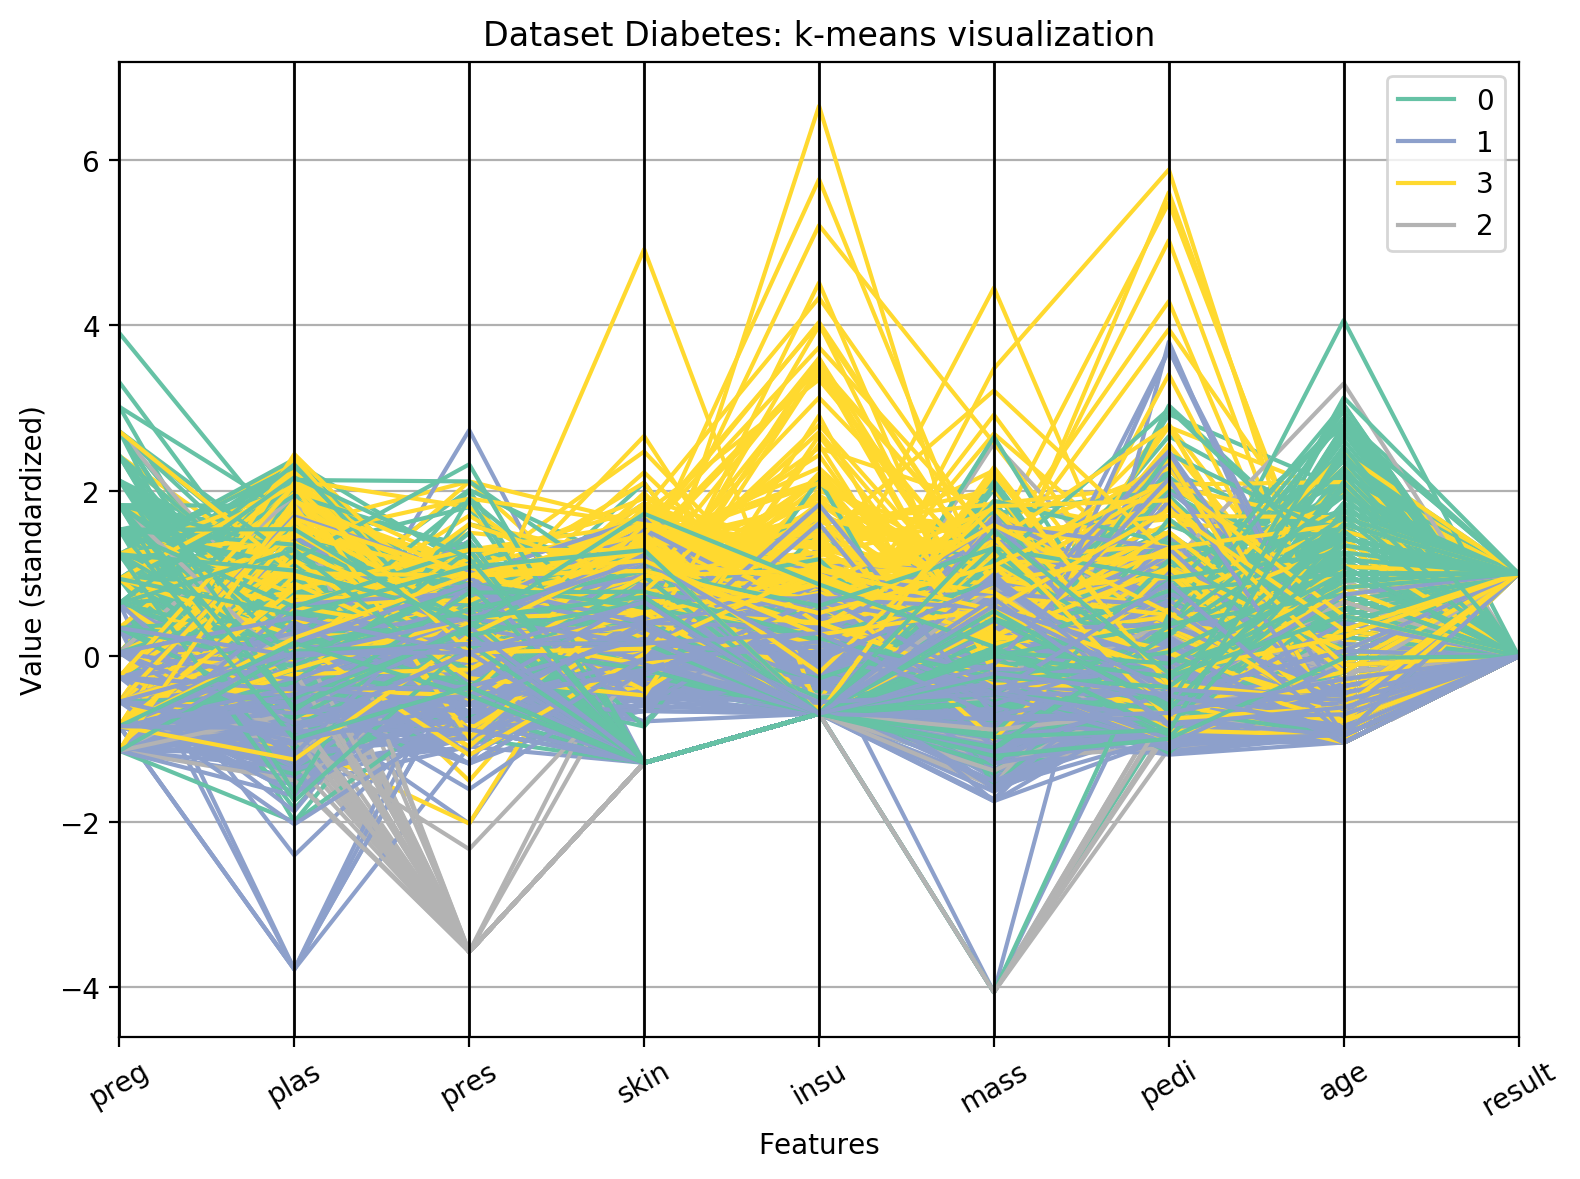

In [35]:
plotClustersDiabetes(X1,Y1)

[212 344  36 176]


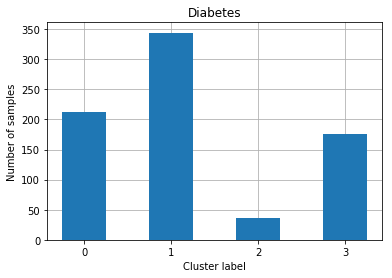

In [36]:
plotClustersHistogram(X1,Y1,4,'Diabetes')

       preg      plas      pres      skin      insu      mass      pedi  \
0  0.639947  0.848324  0.149641  0.907270 -0.692891  0.204013  0.468492   
1 -0.844885 -1.123396 -0.160546  0.530902 -0.692891 -0.684422 -0.365061   
2  1.233880  1.943724 -0.263941 -1.288212 -0.692891 -1.103255  0.604397   
3 -0.844885 -0.998208 -0.160546  0.154533  0.123302 -0.494043 -0.920763   
4 -1.141852  0.504055 -1.504687  0.907270  0.765836  1.409746  5.484909   

        age  result  class  
0  1.425995       1      0  
1 -0.190672       0      1  
2 -0.105584       1      0  
3 -1.041549       0      1  
4 -0.020496       1      3  


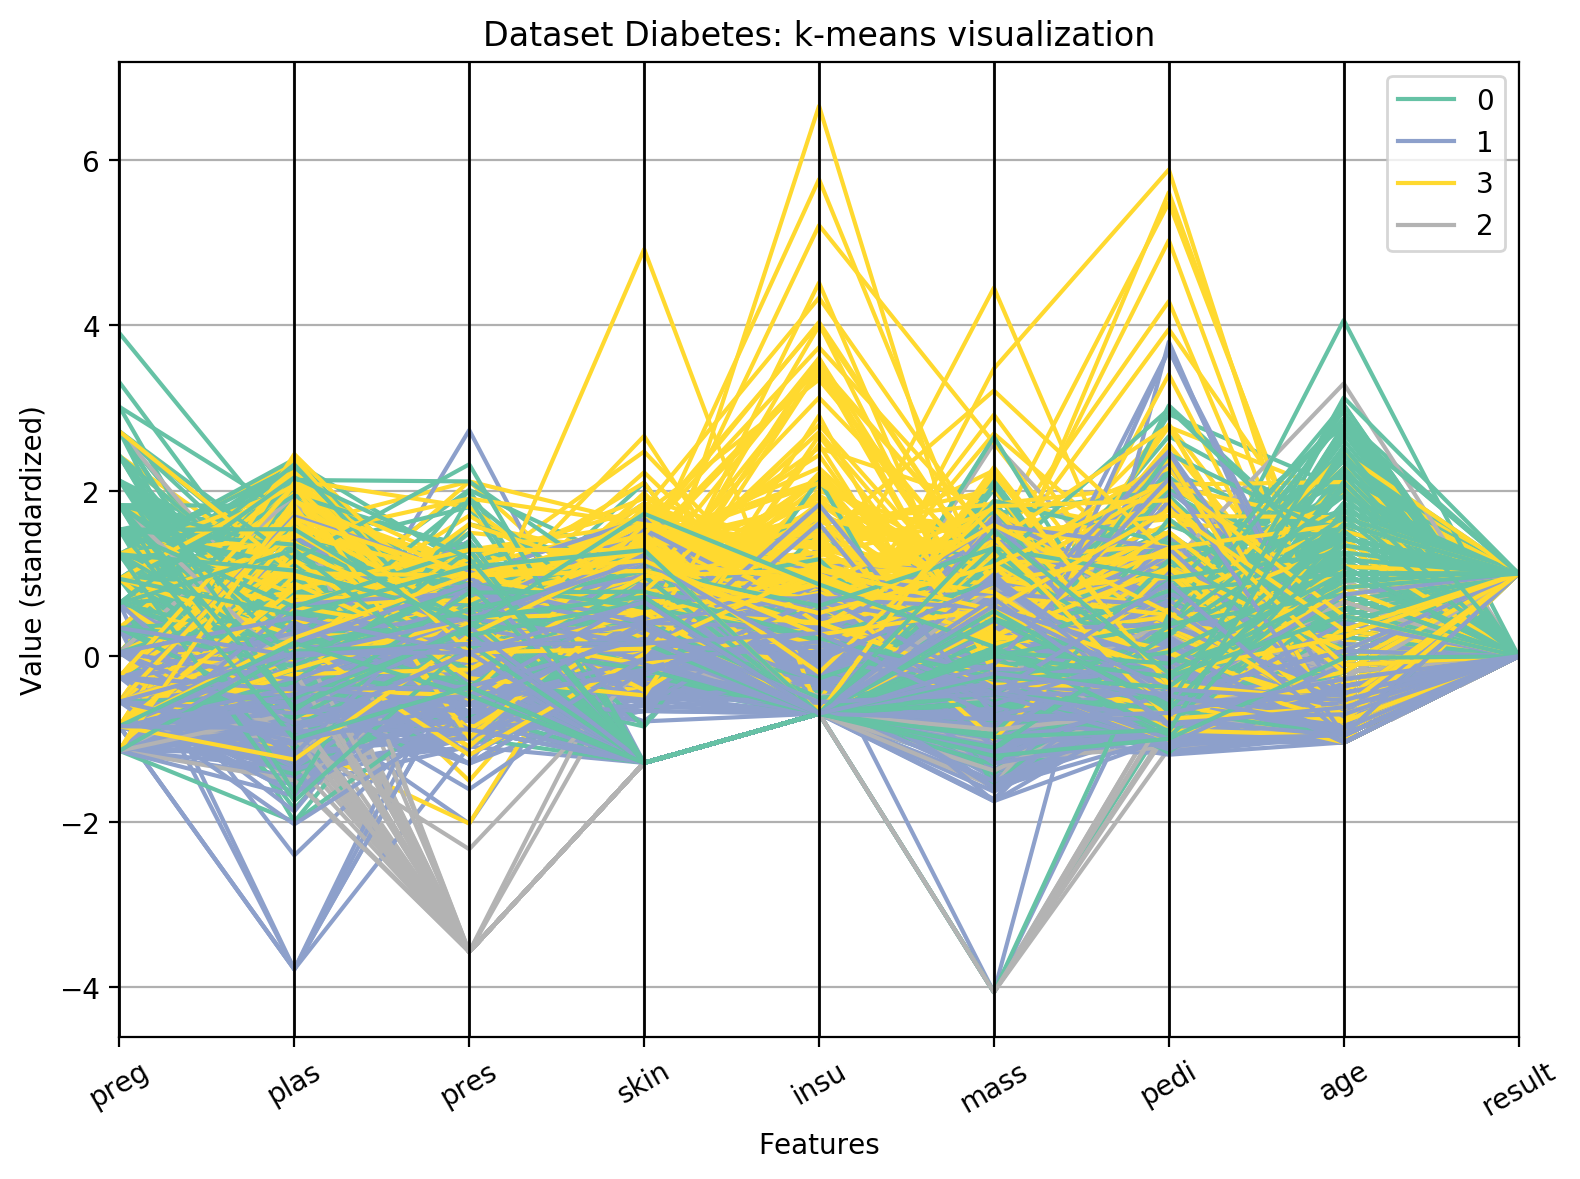

In [37]:
plotClustersDiabetes(X1,Y1)

## Expectation Maximization 

  ## Cluster vizualization with features for EM¶

In [38]:
def plotEMHistogram(x,y,k1,dataset):
    random_seed = 7641
    em = EM(n_components=k1,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    em.fit(x)
    plt.figure()
   #Store the labels
    labels = em.predict(x)

    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print(counts)
    #Output : [243 244 245]
    #print(kmeans.labels_)
    plt.hist(labels, bins=np.arange(0, k1 + 1) - 0.5, rwidth=0.5, zorder=2)
    plt.xticks(np.arange(0, k1))
    plt.xlabel('Cluster label')
    plt.ylabel('Number of samples')
    plt.title(dataset)
    plt.grid()
    name='em_hist_'+dataset+'.png'
    plt.savefig(name)
    
def plotEMDiabetes(x,y,k1):
    #for diabetes

    df1 = pd.read_csv('pima_diabetes.csv', nrows=1)
    to_drop = ['class']
    df1 = df1.drop(to_drop, axis=1)
    cols1 = df1.columns
    random_seed = 7641
    em = EM(n_components=k1,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    em.fit(x)
    labels = em.predict(x)
    df1 = pd.DataFrame(x, columns = cols1)
    df1['result'] = y
    df1['class'] = labels
    print(df1.head(5))

    # Parallel coordinates plot
    rand_idx1 = np.arange(0,8,1)#all features
    idx_viz1 = np.append(rand_idx1, [df1.shape[1] - 2, df1.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df1.iloc[:, idx_viz1], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Diabetes: EM visualization')
    plt.tight_layout()
    plt.savefig('Em_viz_1.png')
    

def plotEMWine(x,y,k1):
      
    #for wine data
    df2 = pd.read_csv('wine-quality-red.csv', nrows=1)
    to_drop = ['class']
    df2 = df2.drop(to_drop, axis=1)
    cols2 = df2.columns
    random_seed = 7641
    em = EM(n_components=k1,covariance_type='full',n_init=1,warm_start=False,random_state=20)
    em.fit(x)
    labels = em.predict(x)
    df2 = pd.DataFrame(x, columns = cols2)
    df2['result'] = y
    df2['class'] = labels
    print(df2.head(5))

    # Parallel coordinates plot
    rand_idx2 = np.arange(0,11,1)#all 11 features
    #print(rand_idx2)
    idx_viz2 = np.append(rand_idx2, [df2.shape[1] - 2, df2.shape[1] - 1])    # Add ground truth label and cluster label

    # plt.figure(figsize=(10, 7.5), dpi=250)
    plt.figure(figsize=(8, 6), dpi=200)
    pd.plotting.parallel_coordinates(df2.iloc[:, idx_viz2], 'class', colormap='Set2')
    plt.xticks(rotation=30)
    plt.xlabel('Features')
    plt.ylabel('Value (standardized)')
    plt.title('Dataset Wines: EM visualization')
    plt.tight_layout()
    plt.savefig('Em_viz_2.png')

[142  86 246 194  35  65]


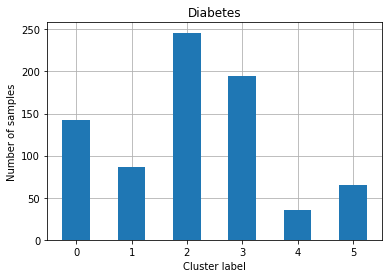

In [39]:
plotEMHistogram(X1,Y1,6,'Diabetes')

       preg      plas      pres      skin      insu      mass      pedi  \
0  0.639947  0.848324  0.149641  0.907270 -0.692891  0.204013  0.468492   
1 -0.844885 -1.123396 -0.160546  0.530902 -0.692891 -0.684422 -0.365061   
2  1.233880  1.943724 -0.263941 -1.288212 -0.692891 -1.103255  0.604397   
3 -0.844885 -0.998208 -0.160546  0.154533  0.123302 -0.494043 -0.920763   
4 -1.141852  0.504055 -1.504687  0.907270  0.765836  1.409746  5.484909   

        age  result  class  
0  1.425995       1      0  
1 -0.190672       0      0  
2 -0.105584       1      3  
3 -1.041549       0      2  
4 -0.020496       1      5  


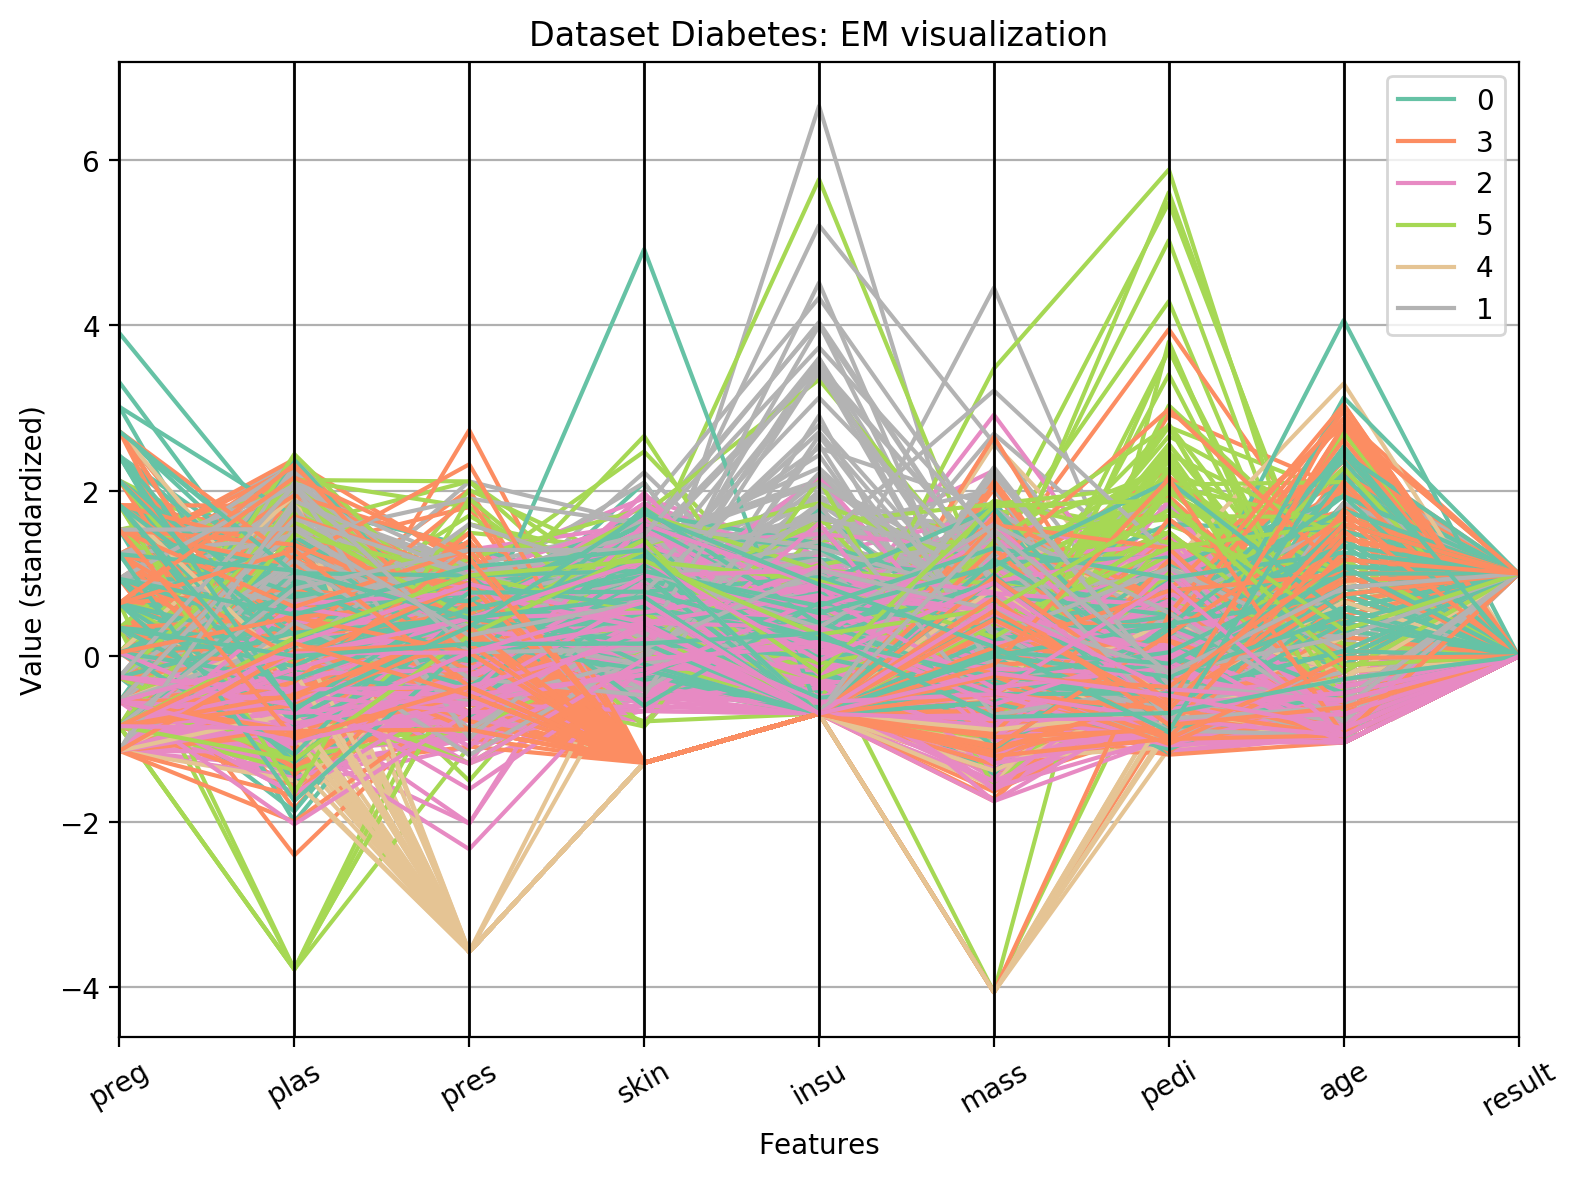

In [40]:
plotEMDiabetes(X1,Y1,6)

# EM program

In [41]:
def run_EM(X,y,title,n=30,file=''):

    kdist = list(np.arange(2,n))
    sil_scores = []; c_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []; v_scores=[]
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=False,random_state=20)
        end_time = timeit.default_timer()
        em.fit(X)
        train_times.append(end_time - start_time)
        em_labels = em.predict(X)
        sil_scores.append(sil_score(X, em_labels))
        c_scores.append(completeness_score(y, em_labels))
        homo_scores.append(homogeneity_score(y, em_labels))
        v_scores.append(v_measure_score(y, em_labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # curve for silhouette score
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Silhoutte vs No. of clusters')
    fname = 'Sil_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
   
    # plot scores    
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kdist, homo_scores, color="r", label="Homogeneity Scores")
    ax.plot(kdist, c_scores, color="g", label="Completeness Scores")
    #ax.plot(kdist, v_scores, color="b", label="V Measure Scores")
    plt.grid(True)
    plt.xlabel('number of components')
    plt.ylabel('Score')
    plt.title('Scores vs number of components')
    plt.legend(loc="best")
    fname = 'Score_'+file+'.jpg'
    plt.savefig(fname)
    plt.show() 

    # plot model AIC and BIC
    fig = plt.figure()
    plt.suptitle(title, fontsize=12, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.plot(kdist, (aic_scores), label='AIC')
    ax.plot(kdist, (bic_scores),label='BIC')
    #ax.plot(kdist, np.gradient(aic_scores), label='Gradient AIC')
    #ax.plot(kdist, np.gradient(bic_scores),label='Gradient BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('BIC vs number of components')
    plt.legend(loc="best")
    fname = 'BIC_'+file+'.jpg'
    plt.savefig(fname)
    plt.show()
    
    
def evaluate_EM(em, X, y, title = ''):
    start_time = timeit.default_timer()
    em.fit(X)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)    
    accuracy = accuracy_score(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote: "+title)
    print("****************************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("V Measure Score: {:.2f}".format(v_measure_score(y, labels)))  
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    
    print("****************************************************************")
    plt.figure()
    plt.show()

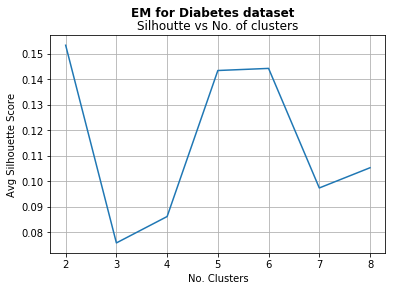

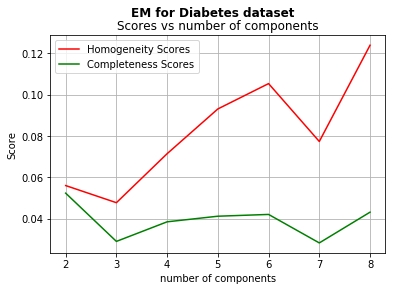

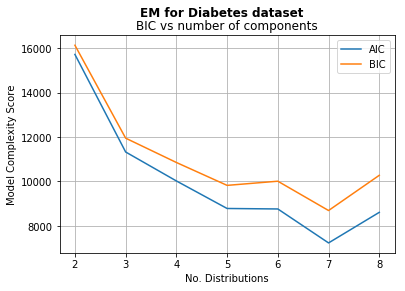

In [42]:
run_EM(X1,Y1,n=9,title='EM for Diabetes dataset', file="EM_D")

In [43]:
em = EM(n_components=5, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, 
                     init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=20, 
                     warm_start=False, verbose=0, verbose_interval=10)
evaluate_EM(em,X2,Y2,title = "EM-Diabetes")
em = EM(n_components=6, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, 
                     init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=20, 
                     warm_start=False, verbose=0, verbose_interval=10)
evaluate_EM(em,X2,Y2,title = "EM-Diabetes")

Model Evaluation Metrics Using Mode Cluster Vote: EM-Diabetes
****************************************************************
Model Training Time (s):   0.09
No. Iterations to Converge: 34
Log-likelihood Lower Bound: -9.97
V Measure Score: 0.08
Accuracy:  0.53
****************************************************************


<Figure size 432x288 with 0 Axes>

Model Evaluation Metrics Using Mode Cluster Vote: EM-Diabetes
****************************************************************
Model Training Time (s):   0.08
No. Iterations to Converge: 19
Log-likelihood Lower Bound: -9.81
V Measure Score: 0.09
Accuracy:  0.54
****************************************************************


<Figure size 432x288 with 0 Axes>

In [44]:
import seaborn as sns
def plot_ICA_Diabetes(x,y,title=''):
        result = pd.DataFrame()
        result['class']=y
        ica = FICA(random_state=20)
        data = ica.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='g', label = '0')
            sns.distplot(data[i][result['class']==1], color='r', label = '1')
            plt.legend(loc='best')
        fig.suptitle(title)
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('ICA_Diabetes_KurtosisPlots.png')
        plt.show()

[2, 3, 4, 5, 6, 7]
           0         1         2         3         4         5         6  \
0  -0.029960  0.045426  0.001645 -0.003891 -0.053101  0.041653 -0.017246   
1   0.020689  0.028083  0.023295  0.006699  0.003350  0.035284  0.011755   
2  -0.076351 -0.046131  0.044714 -0.000913  0.000150  0.011989 -0.027462   
3   0.019182 -0.011888  0.014652  0.008554  0.021908 -0.003523  0.033343   
4   0.006284  0.023494 -0.027799 -0.073413  0.004846 -0.004699 -0.197007   
5  -0.000980 -0.024531  0.017905  0.017177  0.028010  0.006954  0.026068   
6   0.037730 -0.008639  0.011411 -0.026627 -0.017260  0.004225  0.025830   
7   0.012085 -0.070855 -0.000217 -0.141852 -0.038227 -0.001824  0.035358   
8  -0.047469  0.093929  0.017746  0.004129 -0.040909 -0.140568  0.045522   
9  -0.005800  0.048012  0.132135  0.097676 -0.006398  0.005891  0.019992   
10  0.014488 -0.025154 -0.046039  0.029084  0.046236  0.007595  0.029076   
11 -0.043299 -0.067034 -0.027703 -0.008831 -0.007600  0.008819 -0.009

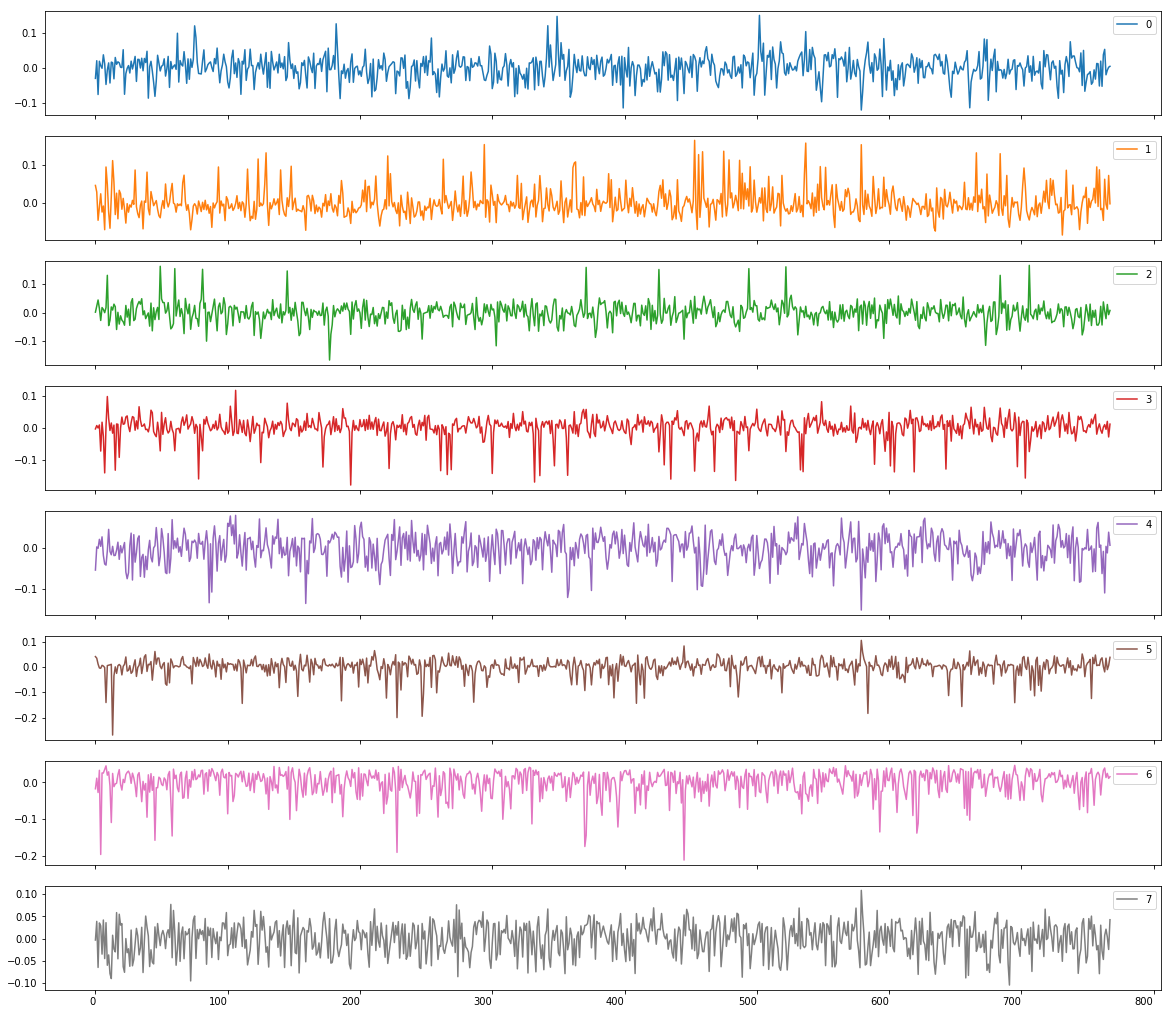

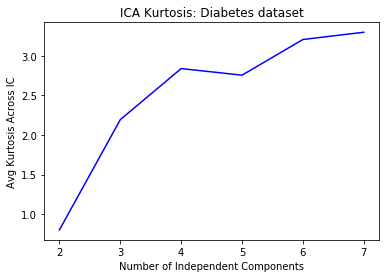

In [45]:
run_ICA(X1,Y1,title = "Diabetes dataset",file= "D")

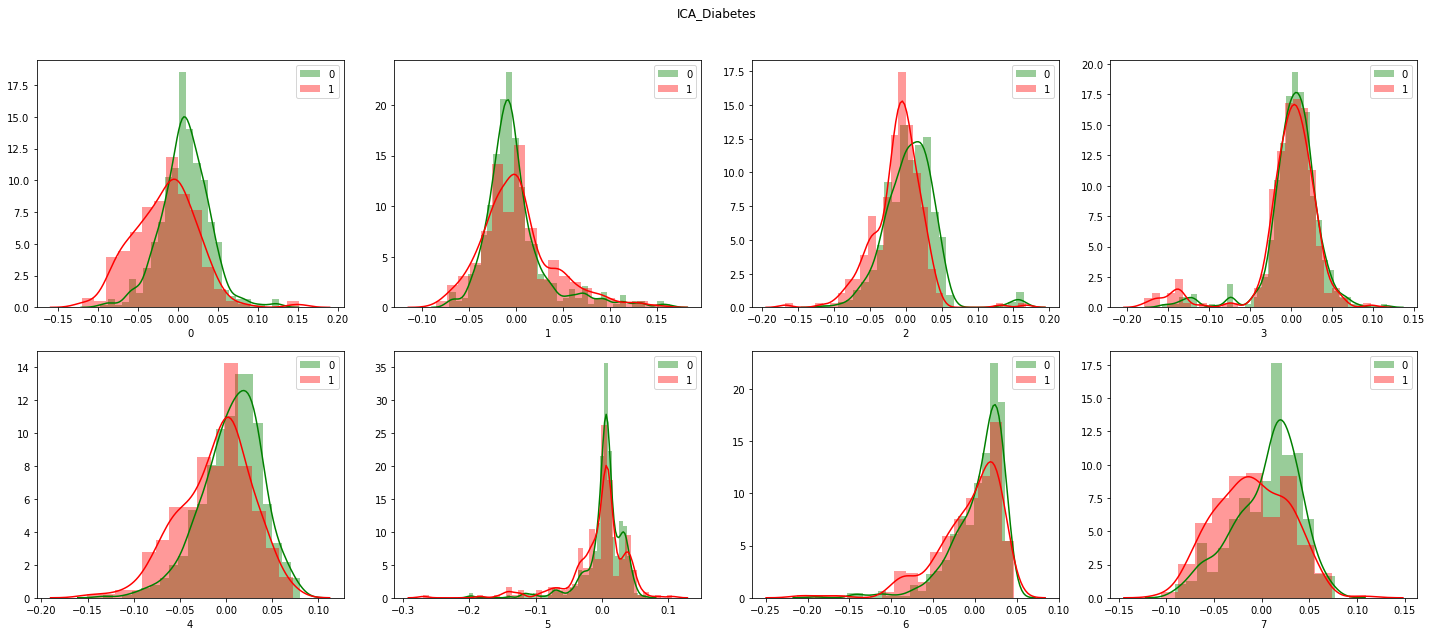

In [46]:
plot_ICA_Diabetes(X1,Y1,title = "ICA_Diabetes")


[2, 3, 4, 5, 6, 7]
           0         1         2         3         4         5         6  \
0  -0.029960  0.045426  0.001645 -0.003891 -0.053101  0.041653 -0.017246   
1   0.020689  0.028083  0.023295  0.006699  0.003350  0.035284  0.011755   
2  -0.076351 -0.046131  0.044714 -0.000913  0.000150  0.011989 -0.027462   
3   0.019182 -0.011888  0.014652  0.008554  0.021908 -0.003523  0.033343   
4   0.006284  0.023494 -0.027799 -0.073413  0.004846 -0.004699 -0.197007   
5  -0.000980 -0.024531  0.017905  0.017177  0.028010  0.006954  0.026068   
6   0.037730 -0.008639  0.011411 -0.026627 -0.017260  0.004225  0.025830   
7   0.012085 -0.070855 -0.000217 -0.141852 -0.038227 -0.001824  0.035358   
8  -0.047469  0.093929  0.017746  0.004129 -0.040909 -0.140568  0.045522   
9  -0.005800  0.048012  0.132135  0.097676 -0.006398  0.005891  0.019992   
10  0.014488 -0.025154 -0.046039  0.029084  0.046236  0.007595  0.029076   
11 -0.043299 -0.067034 -0.027703 -0.008831 -0.007600  0.008819 -0.009

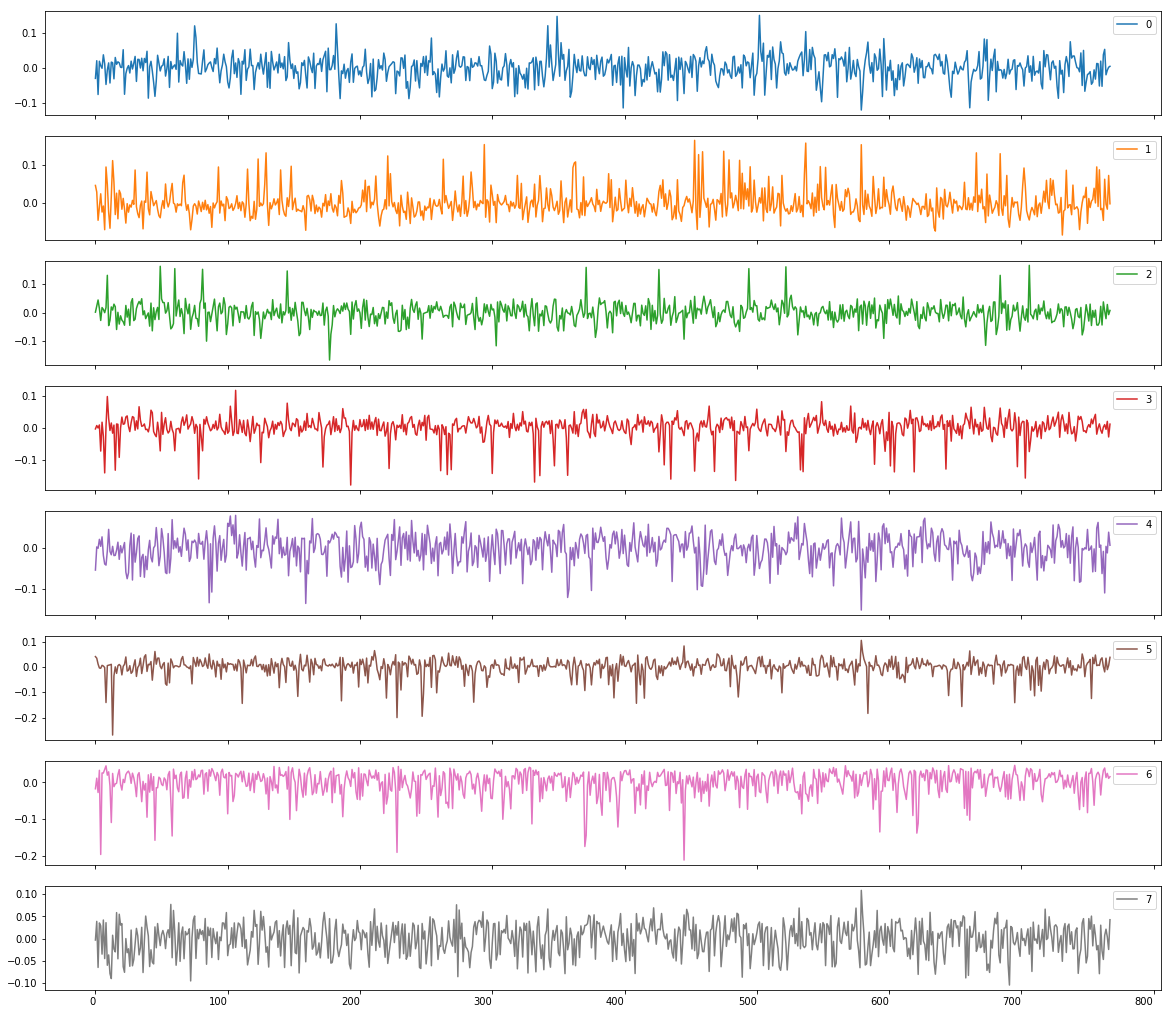

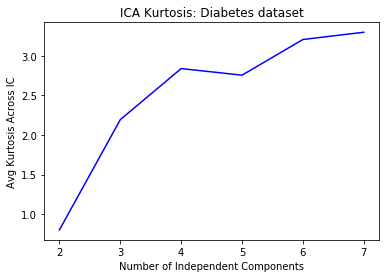

In [47]:
run_ICA(X1,Y1,title = "Diabetes dataset",file= "D")


In [48]:
def plot_PCA_diabetes(x,y,title='',file=""):
        result = pd.DataFrame()
        result['class']=y
        pca = PCA(random_state=20)
        data = pca.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='g', label = '0')
            sns.distplot(data[i][result['class']==1], color='r', label = '1')
            plt.legend(loc='best')
        fig.suptitle('Diabetes')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('PCA_Diabetes_KurtosisPlots.png')

        plt.show()

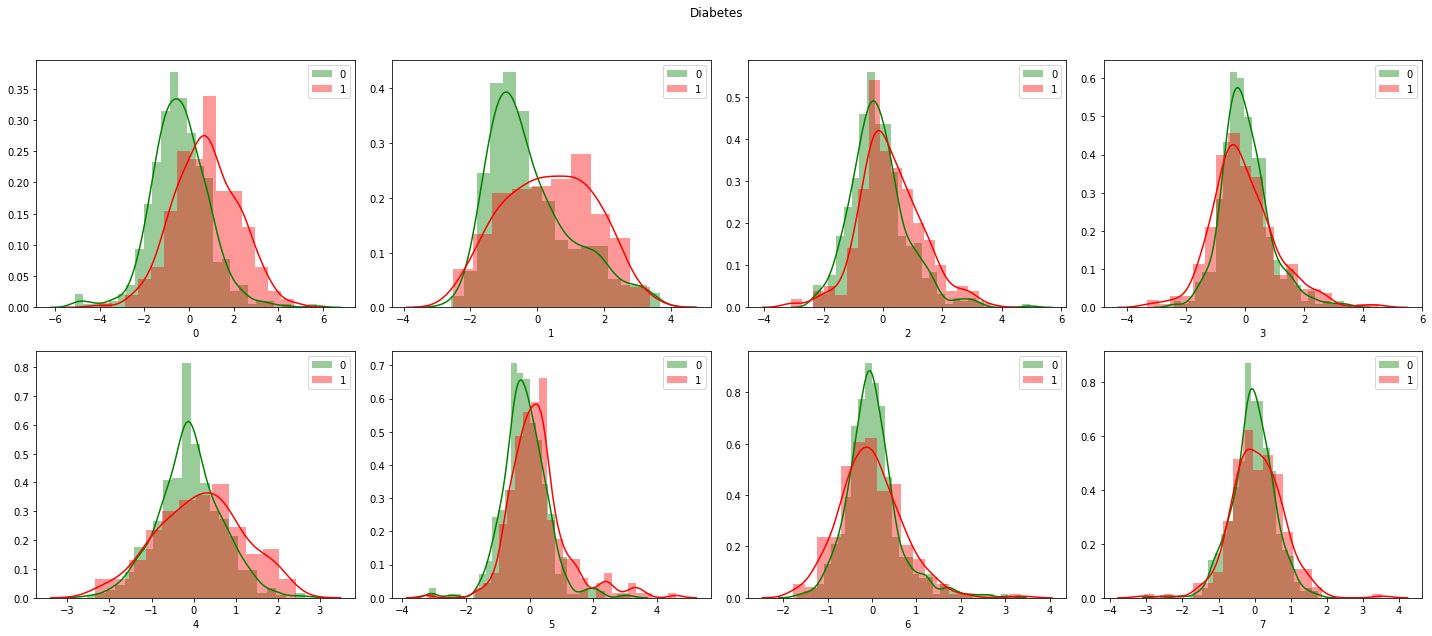

In [49]:
plot_PCA_diabetes(X1,Y1,title = "Diabetes dataset",file= "D")

In [50]:
from sklearn import (random_projection)
def plot_RCA_diabetes(x,y):
        result = pd.DataFrame()
        result['class']=y
        rca = RCA(random_state=20,n_components=8)
        data = rca.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='g', label = '0')
            sns.distplot(data[i][result['class']==1], color='r', label = '1')
            plt.legend(loc='best')
        fig.suptitle('Diabetes')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('RCA_Diabetes_KurtosisPlots.png')
        plt.show()
        

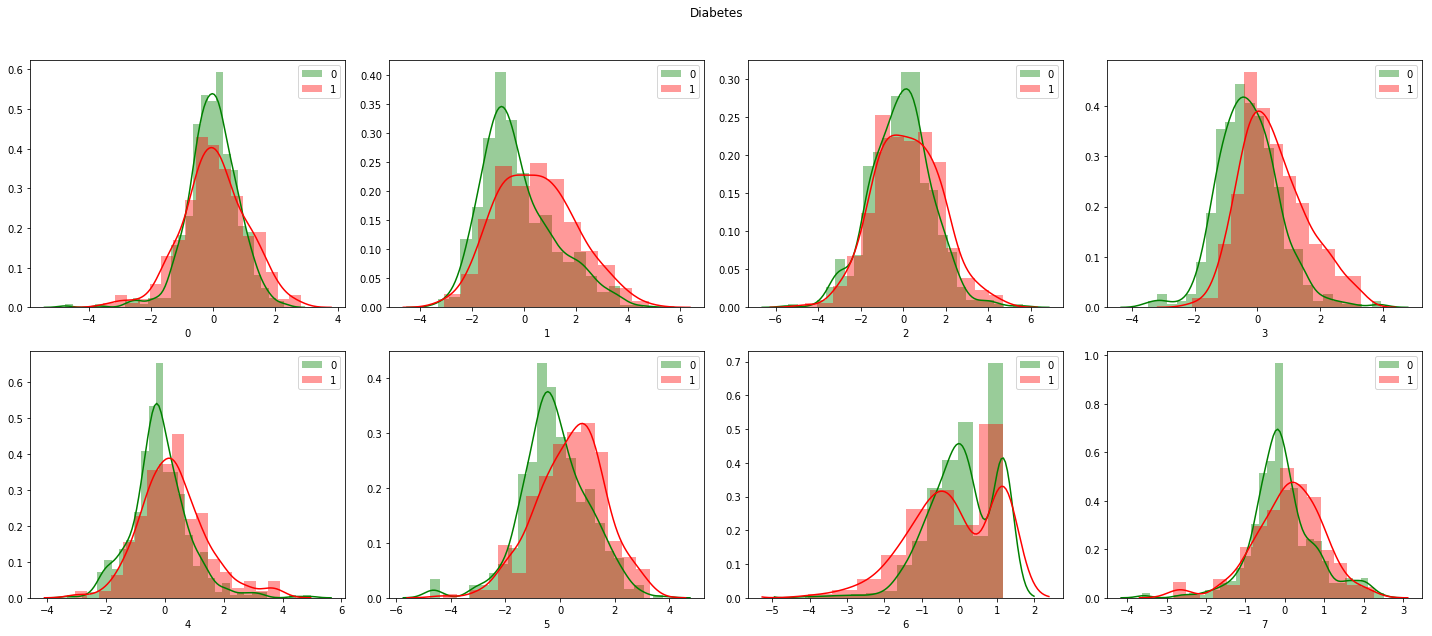

In [51]:
plot_RCA_diabetes(X1,Y1)

In [52]:
def plot_DataKurt_diabetes(x,y):
        result = pd.DataFrame()
        result['class']=y
        #rca = RCA(random_state=20,n_components=8)
        data =x# rca.fit_transform(x)
        data = pd.DataFrame(data)
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in data.columns:
            plt.subplot(6, 4, j+1)
            j += 1
            sns.distplot(data[i][result['class']==0], color='g', label = '0')
            sns.distplot(data[i][result['class']==1], color='r', label = '1')
            plt.legend(loc='best')
        fig.suptitle('Diabetes')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig('Data_Diabetes_KurtosisPlots.png')
        plt.show()

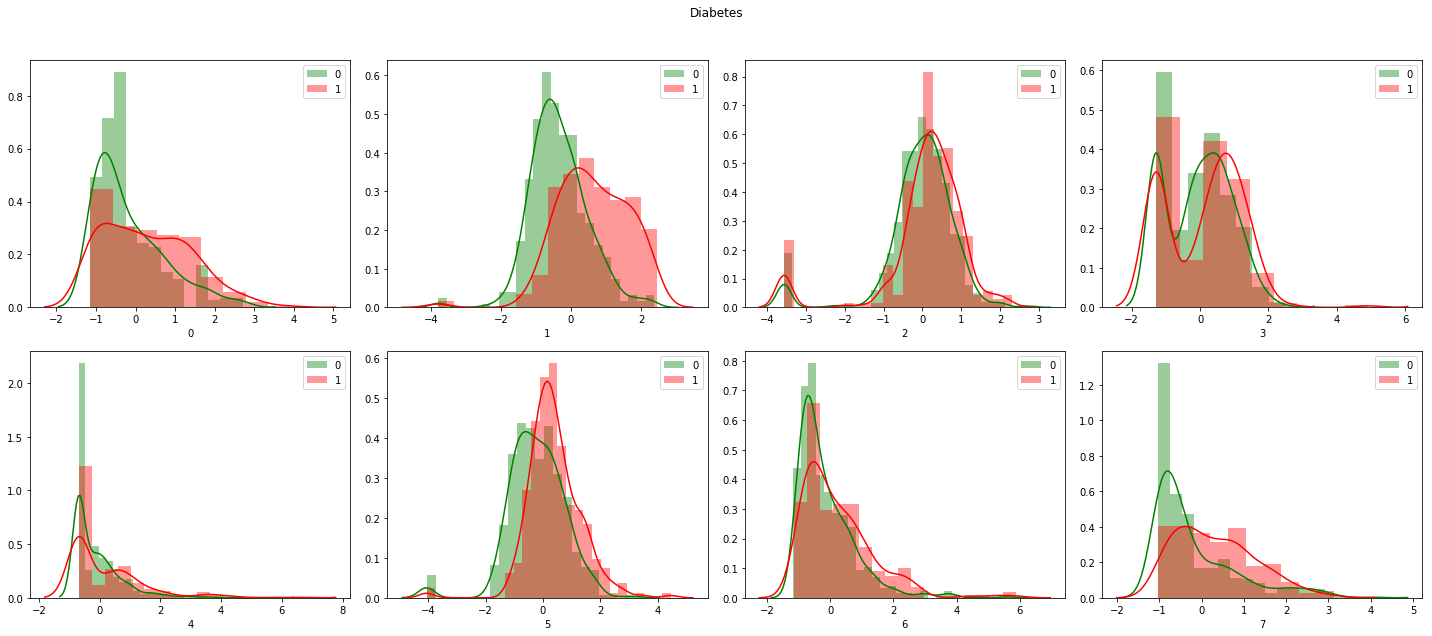

In [53]:
plot_DataKurt_diabetes(X1,Y1)

[2.09711056 1.73346726 1.03097228 0.87667054 0.76333832 0.68351839
 0.42036353 0.40498938]


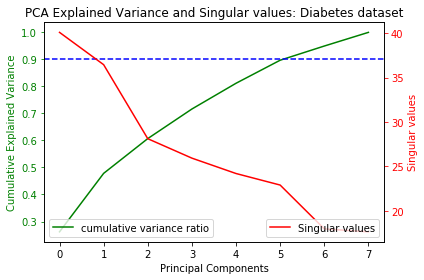

[2, 3, 4, 5, 6, 7]
           0         1         2         3         4         5         6  \
0  -0.029960  0.045426  0.001645 -0.003891 -0.053101  0.041653 -0.017246   
1   0.020689  0.028083  0.023295  0.006699  0.003350  0.035284  0.011755   
2  -0.076351 -0.046131  0.044714 -0.000913  0.000150  0.011989 -0.027462   
3   0.019182 -0.011888  0.014652  0.008554  0.021908 -0.003523  0.033343   
4   0.006284  0.023494 -0.027799 -0.073413  0.004846 -0.004699 -0.197007   
5  -0.000980 -0.024531  0.017905  0.017177  0.028010  0.006954  0.026068   
6   0.037730 -0.008639  0.011411 -0.026627 -0.017260  0.004225  0.025830   
7   0.012085 -0.070855 -0.000217 -0.141852 -0.038227 -0.001824  0.035358   
8  -0.047469  0.093929  0.017746  0.004129 -0.040909 -0.140568  0.045522   
9  -0.005800  0.048012  0.132135  0.097676 -0.006398  0.005891  0.019992   
10  0.014488 -0.025154 -0.046039  0.029084  0.046236  0.007595  0.029076   
11 -0.043299 -0.067034 -0.027703 -0.008831 -0.007600  0.008819 -0.009

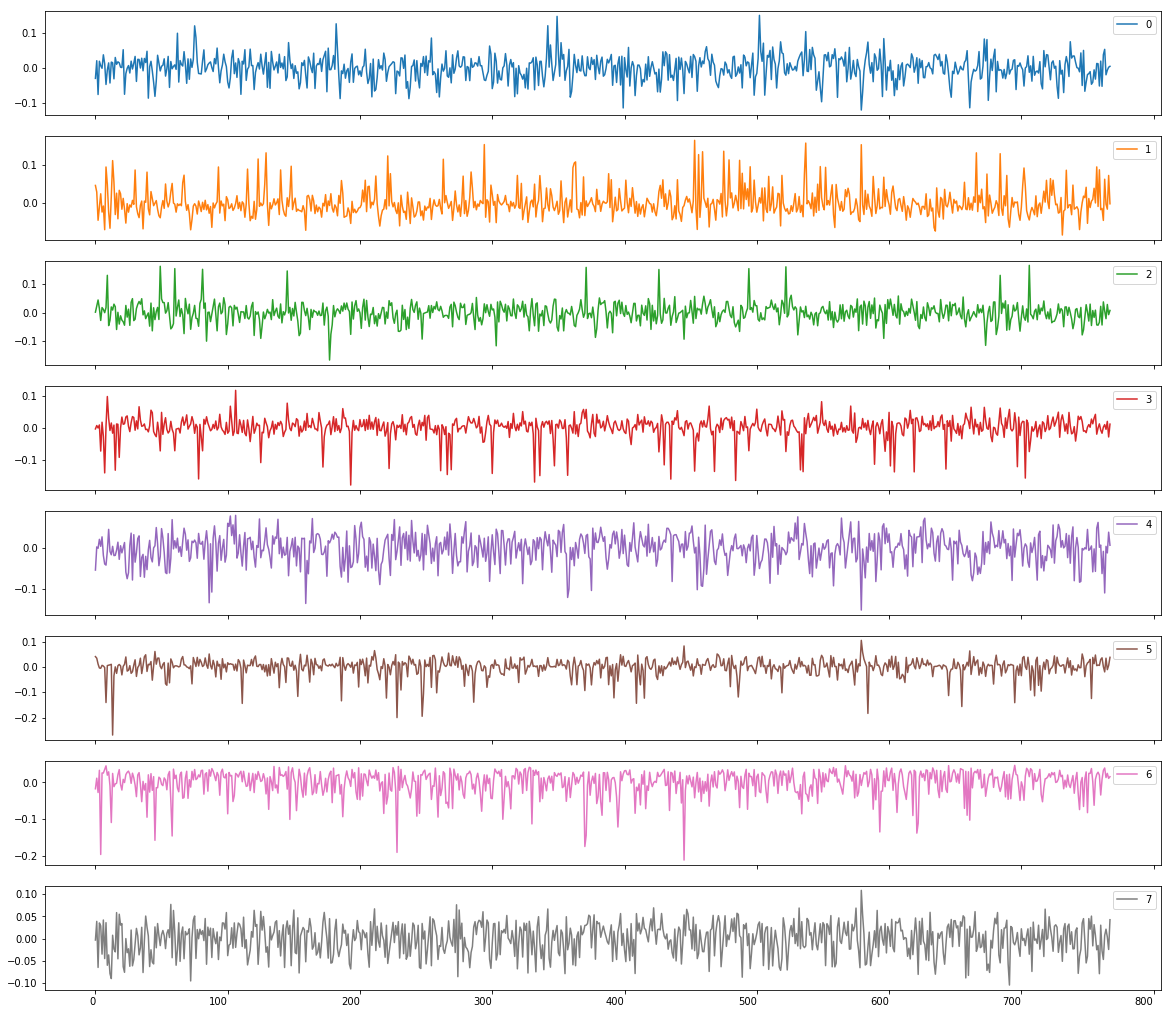

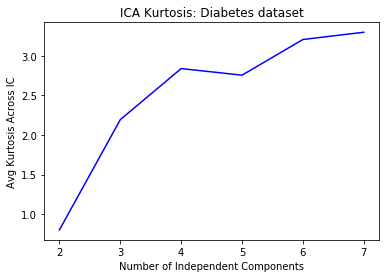

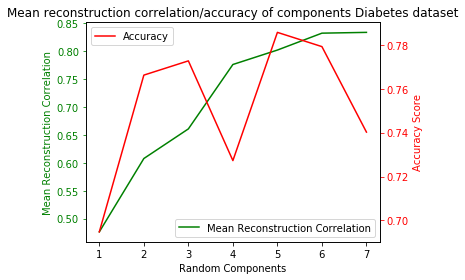

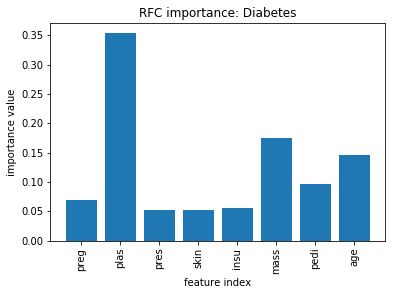

imp        Feature Importance   Cum Sum
plas            0.353222  0.353222
mass            0.175175  0.528397
age             0.146071  0.674468
pedi            0.096503  0.770971
preg            0.069013  0.839984
insu            0.055948  0.895933
selected_cols  ['plas', 'mass', 'age', 'pedi', 'preg', 'insu']


In [54]:
run_PCA(X1,Y1,title = "Diabetes dataset", file= "D")
run_ICA(X1,Y1,title = "Diabetes dataset",file= "D")
run_RCA(X1,Y1,title = "Diabetes dataset",file= "D")
cumsum_features1, selected_features1 = run_RFC(X1,Y1,df_diabetes,title='Diabetes', file ="D")

In [122]:
pca_dia = PCA(n_components=5,random_state=5).fit_transform(X1)
ica_dia = FICA(n_components=6,random_state=5).fit_transform(X1)
rca_dia = RCA(n_components=5,random_state=5).fit_transform(X1)
rfc_dia = df_diabetes[selected_features1]
rfc_dia = np.array(rfc_dia.values)

[0.062228529808886685, 0.0908781783991851, 0.0775532129381482, 0.087798078055817, 0.06025036323882789, 0.06630856558242162]


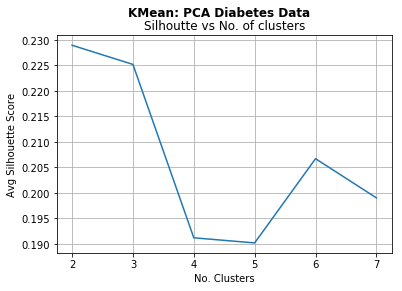

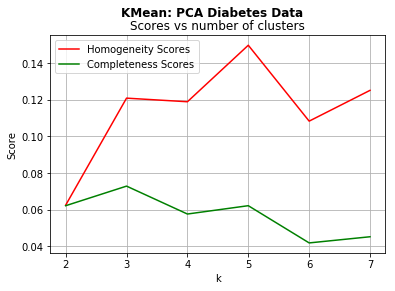

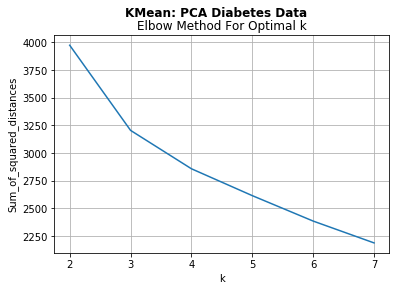

[0.05494744861566858, 0.01646209581348101, 0.05070057598949897, 0.06454711955816433, 0.06054089824765134, 0.07693672209191756]


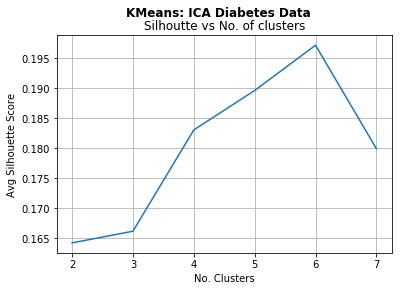

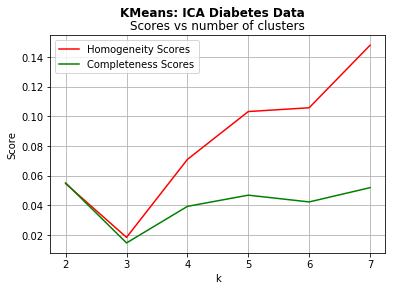

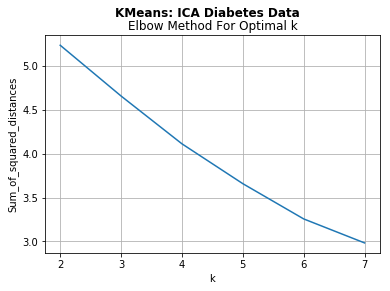

[0.002282715193338296, 0.04769344102871613, 0.04322268877030918, 0.034976149391820734, 0.036149320456274336, 0.040181004538533856]


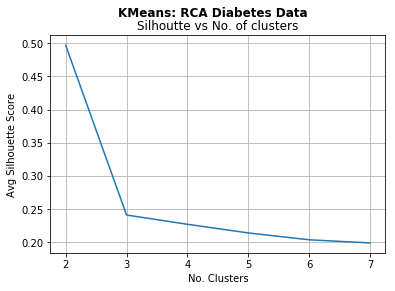

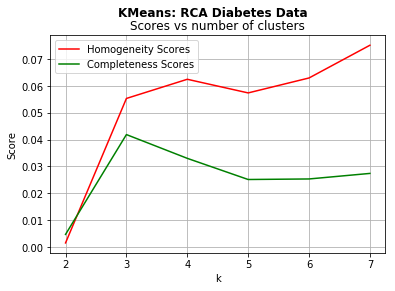

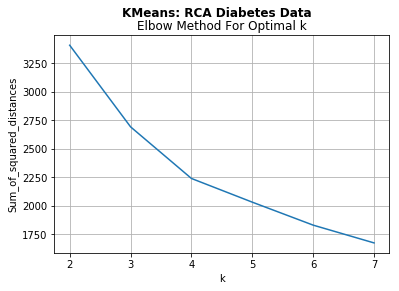

[0.030153875710405703, 0.016782836814668974, 0.022120877662281407, 0.04747773369041074, 0.07170404039924663, 0.07215703034875127]


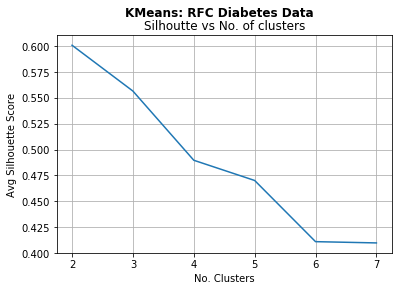

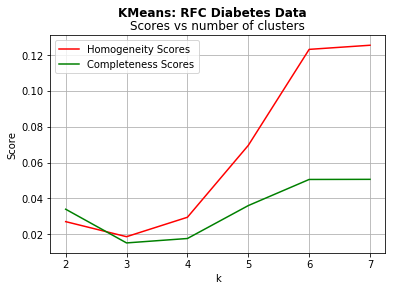

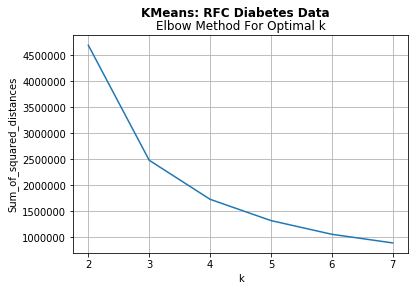

In [56]:
# K means 
run_kmeans(pca_dia,Y1, n = 8, title='KMean: PCA Diabetes Data', file= "Kmeans_pca_D")
run_kmeans(ica_dia,Y1, n = 8,title='KMeans: ICA Diabetes Data', file= "Kmeans_ica_D")
run_kmeans(rca_dia,Y1, n = 8,title='KMeans: RCA Diabetes Data', file= "Kmeans_rca_D")
run_kmeans(rfc_dia,Y1, n = 8,title='KMeans: RFC Diabetes Data', file= "Kmeans_rfc_D")

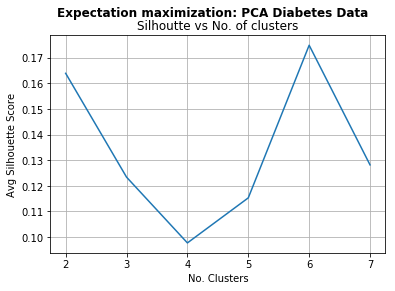

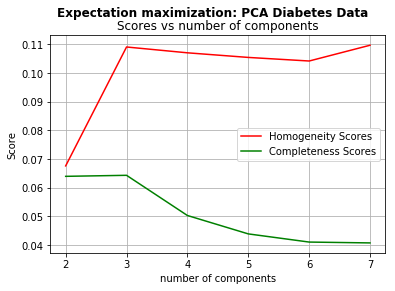

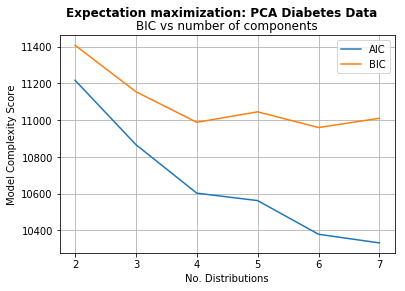

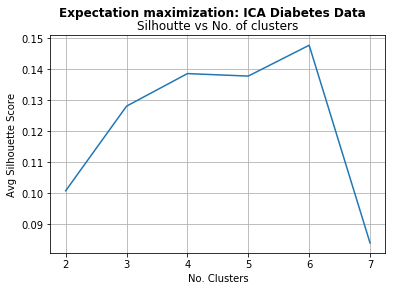

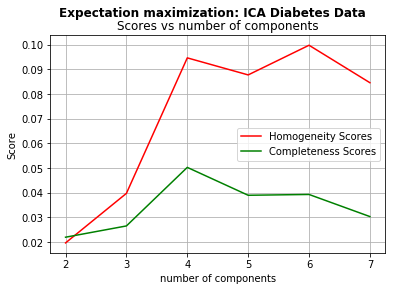

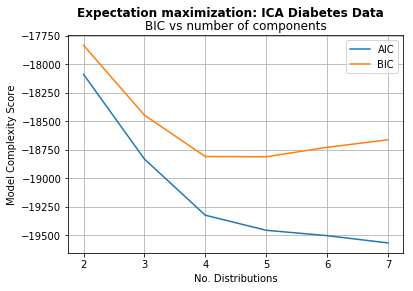

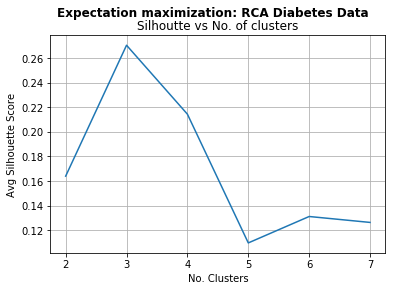

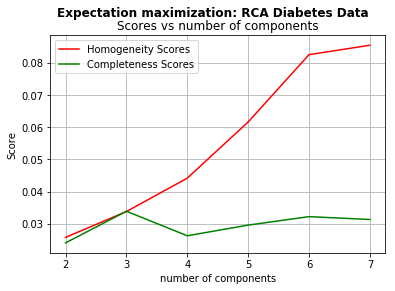

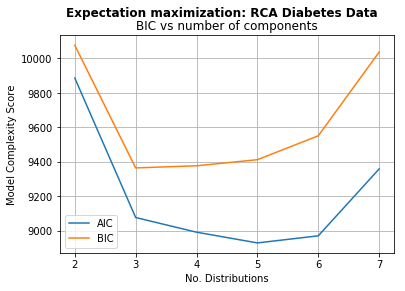

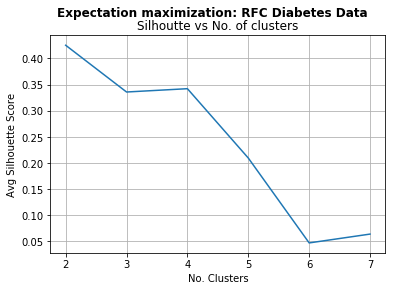

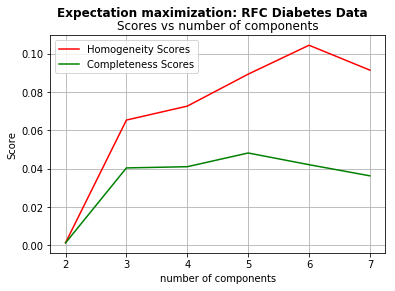

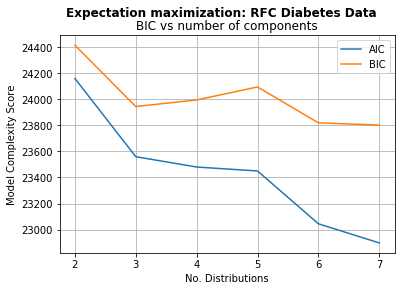

In [57]:
# Expectation maximization
run_EM(pca_dia,Y1,n =8,title='Expectation maximization: PCA Diabetes Data', file= "EM_pca_D")
run_EM(ica_dia,Y1,n =8,title='Expectation maximization: ICA Diabetes Data', file= "EM_ica_D")
run_EM(rca_dia,Y1,n =8,title='Expectation maximization: RCA Diabetes Data', file= "EM_rca_D")
run_EM(rfc_dia,Y1,n =8,title='Expectation maximization: RFC Diabetes Data', file= "EM_rfc_D")

[3.10107182 1.92711489 1.55151379 1.21399175 0.95989238 0.66002104
 0.58415655 0.42322138 0.34485779 0.18144664 0.05959558]


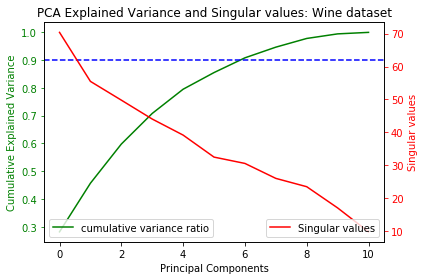

[2, 3, 4, 5, 6, 7, 8, 9, 10]
          0         1         2         3         4         5         6   \
0   0.004453  0.001575 -0.001561 -0.024107 -0.011104  0.034659 -0.009520   
1  -0.021381 -0.012029 -0.014937  0.020625 -0.001354  0.047832  0.002238   
2   0.003869 -0.008267 -0.001380  0.009444 -0.006246  0.039627 -0.000359   
3   0.005520  0.002423  0.007045 -0.025967 -0.010575 -0.032698 -0.007650   
4   0.004453  0.001575 -0.001561 -0.024107 -0.011104  0.034659 -0.009520   
5   0.001960  0.001455  0.005373 -0.028468 -0.013367  0.034097 -0.010114   
6   0.010186  0.013296  0.011130 -0.009039 -0.014271  0.031047 -0.011088   
7  -0.013924  0.033235 -0.009417  0.016772 -0.014182  0.024375 -0.008076   
8   0.004027  0.017177  0.015998  0.002033 -0.004553  0.029296 -0.008798   
9   0.037715 -0.004355 -0.005635 -0.021496  0.062623 -0.005267 -0.011191   
10  0.017097  0.025597  0.014287 -0.006854 -0.008494  0.028954  0.005106   
11  0.037715 -0.004355 -0.005635 -0.021496  0.062623 -0.005

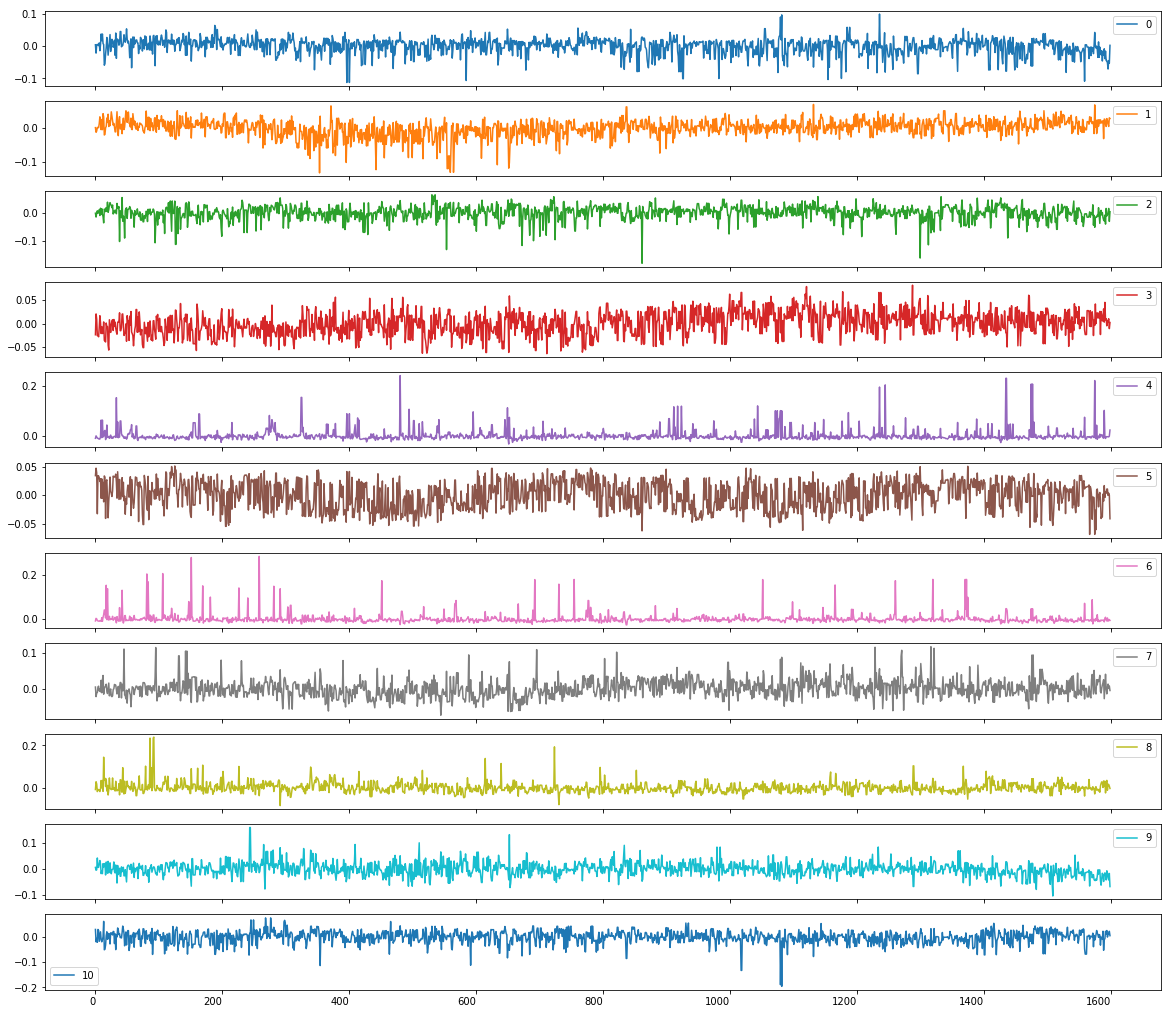

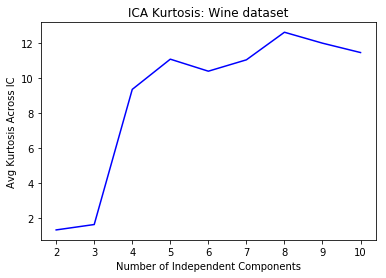

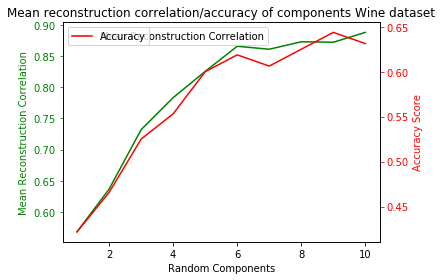

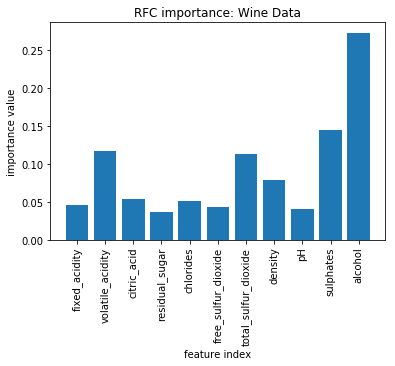

imp                        Feature Importance   Cum Sum
alcohol                         0.272974  0.272974
sulphates                       0.145378  0.418351
volatile_acidity                0.117282  0.535633
total_sulfur_dioxide            0.113920  0.649554
density                         0.079441  0.728995
citric_acid                     0.054486  0.783481
chlorides                       0.050765  0.834246
fixed_acidity                   0.045672  0.879918
selected_cols  ['alcohol', 'sulphates', 'volatile_acidity', 'total_sulfur_dioxide', 'density', 'citric_acid', 'chlorides', 'fixed_acidity']


In [60]:
run_PCA(X2,Y2,title = "Wine dataset", file= "W")
run_ICA(X2,Y2,title = "Wine dataset", file= "W")
run_RCA(X2,Y2,title = "Wine dataset", file= "W")
cumsum_features2, selected_features2 = run_RFC(X2,Y2,df_wine_data,title='Wine Data', file ="W")

## Error after reconstruction

In [61]:
from numpy import linalg as LA
from sklearn import metrics
def recons_error(x,y,n,dataset,opt=""):
    #https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn
    #https://www.kaggle.com/ericlikedata/reconstruct-error-of-pca
    max_comp=n
    start=0
    error_record=[]
    loss=0
    algo=[]
    for i in range(start,max_comp):
        if(opt=="PCA"):
            algo = PCA(n_components=i, random_state=42)
            
        if(opt=="ICA"):
            algo=FICA(random_state=42)
            algo.set_params(n_components=(i+1))
        if(opt=="RCA"):
            algo=RCA(n_components=(i+1), random_state=42)
        algo_results = algo.fit_transform(x)
        #print(algo.mean_.shape)
        #print(algo_results.shape)
        algo_proj_back=algo.inverse_transform(algo_results)
        total_loss=LA.norm((x-algo_proj_back),None)
        #total_loss=((x-algo_proj_back)**2).mean()

        loss=total_loss
        print("Error with "+str(i)+" "+opt+" "+str(loss))
        error_record.append(total_loss)

    plt.clf()
    plt.figure(figsize=(3,3))
    title=opt+ " reconstruction error: "+dataset
    plt.title(title)
    plt.plot(error_record,'r')
    plt.xticks(range(len(error_record)), range(start,max_comp), rotation='vertical')
    plt.xlim([-1, len(error_record)])
    title=title+".png"
    figName=opt+"_ReconsErr_"+dataset+".png"
    plt.savefig(figName)
    plt.show()

from numpy.testing import assert_array_almost_equal
from numpy.linalg import inv
import pandas as pd
def error_RCA(x,y,k,dataset,opt,n):
    #https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn
    #https://www.kaggle.com/ericlikedata/reconstruct-error-of-pca
    max_comp=n
    start=0
    error_record=[]
    loss=0
    algo=[]
    for i in range(start,max_comp):
        algo=RCA(n_components=(i+1), random_state=40)
        algo_results = algo.fit_transform(x)
        algo_proj_back=algo_results*algo.components_+algo_results.mean()
        total_loss=LA.norm((x-algo_proj_back),None)
        #total_loss=((x-algo_proj_back)**2).mean()
        loss=total_loss
        print("Error with "+str(i)+" "+opt+" "+str(loss))
        error_record.append(total_loss)
        
    plt.clf()
    plt.figure(figsize=(10,10))
    title=opt+ " reconstruction error: "+dataset
    plt.title(title)
    plt.plot(error_record,'r')
    plt.xticks(range(len(error_record)), range(start,max_comp), rotation='vertical')
    plt.xlim([-1, len(error_record)])
    title=title+".png"
    figName=opt+"_ReconsErr_"+dataset+".png"
    plt.savefig(figName)
    plt.show()
    
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
    
def error_RCA2(x,y,k,dataset,opt,n):    
# Modified Locally linear embedding of the digits dataset
    max_comp=n
    start=0
    error_record=[]
    loss=0
    algo=[]
    for i in range(start,max_comp):
        
        
        algo=RCA(n_components=(i+1), random_state=42)
        #algo_results = algo.fit_transform(x)
        print("Computing modified LLE embedding")
        #clf = RCA(n_neighbors, n_components=2,

        X_projected = algo.fit_transform(x)
        plot_embedding(X_projected, "Random Projection of the digits")

        #print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
    
    




Error with 0 RCA 122.84899587911013
Error with 1 RCA 120.72213013472901
Error with 2 RCA 218.90610114171363
Error with 3 RCA 130.41409280331834
Error with 4 RCA 110.73559042682459
Error with 5 RCA 80.23235578888796
Error with 6 RCA 96.55840165139952
Error with 7 RCA 93.74198081815344
Error with 8 RCA 87.96741275697404
Error with 9 RCA 67.53195963148258
Error with 10 RCA 58.55853777584456
Error with 11 RCA 64.32353630608354
Error with 12 RCA 58.33471606502964
Error with 13 RCA 53.72478156420121
Error with 14 RCA 54.9631628248107
Error with 15 RCA 56.776694764822345
Error with 16 RCA 54.350700985654356
Error with 17 RCA 47.68734532072731
Error with 18 RCA 46.55402001809527
Error with 19 RCA 50.01965555748279
Error with 20 RCA 41.113242655665296
Error with 21 RCA 44.63575776215253
Error with 22 RCA 41.78900708071498
Error with 23 RCA 42.45982525660059
Error with 24 RCA 44.99071317648217
Error with 25 RCA 43.2255035099439
Error with 26 RCA 43.412909117028995
Error with 27 RCA 35.5814350788

<Figure size 432x288 with 0 Axes>

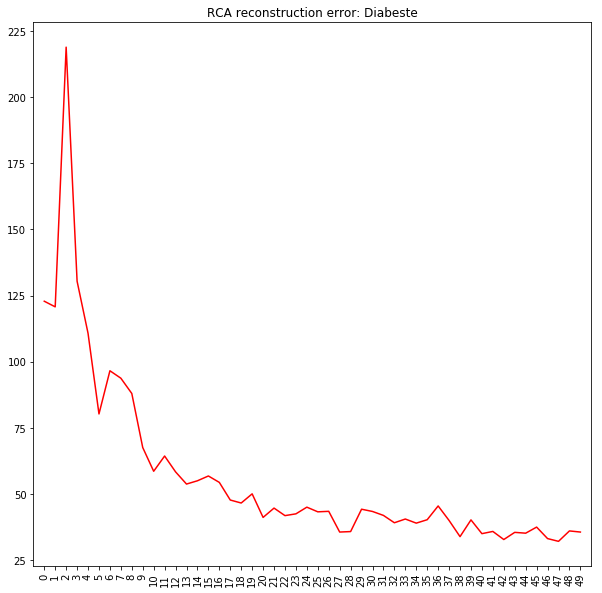

In [62]:
error_RCA(X1, Y1, 4,"Diabeste","RCA",50)

Error with 0 PCA 78.38367176906169
Error with 1 PCA 67.34624118700461
Error with 2 PCA 56.62108100365314
Error with 3 PCA 49.144593542818335
Error with 4 PCA 41.74667374587167
Error with 5 PCA 34.01917519195537
Error with 6 PCA 25.160399019054633
Error with 7 PCA 17.624609294507138


<Figure size 432x288 with 0 Axes>

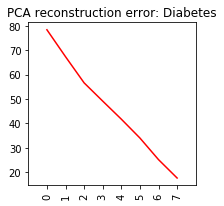

Error with 0 ICA 67.34624118700461
Error with 1 ICA 56.62108100365314
Error with 2 ICA 49.144593542818335
Error with 3 ICA 41.74667374587167
Error with 4 ICA 34.01917519195537
Error with 5 ICA 25.160399019054633
Error with 6 ICA 17.62460929450714
Error with 7 ICA 1.7503086611177634e-13


<Figure size 432x288 with 0 Axes>

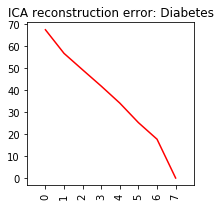

In [63]:
recons_error (X1,Y1,8,'Diabetes',"PCA")
recons_error (X1,Y1,8,'Diabetes',"ICA")

# Neural Networks

In [135]:
def classifier_evaluation(clf,X_train, X_test, y_train, y_test, title=''):    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)

    print("Model Evaluation Metrics "+title+" Test Dataset")
    print("*****************************************************")    
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("F1 Score:   "+"{:.2f}".format(f1))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("*****************************************************")
    plt.figure()
    plt.show()
    return f1, accuracy, precision, recall, training_time, pred_time

def add_clusters(x1, isKM = True):
    df = pd.DataFrame(x1)
    print('x shape ', x1.shape)
    if isKM:
        km = KMeans(n_clusters=4,n_init=10,random_state=20,n_jobs=-1).fit(x1)
        df['KM'] = km.labels_
    else:
        em = EM(n_components=3,covariance_type='full',n_init=1,warm_start=False,random_state=20).fit(x1)
        df['EM'] = em.predict(x1)
    clustered_data = np.array(df)
    return clustered_data

In [136]:
f1 =[]; accuracy= []; precision =[]; recall=[]; training_time=[]; pred_time=[]

nn = MLPClassifier(hidden_layer_sizes=(5,5), activation='identity', solver='lbfgs', alpha=0.5, 
                        batch_size='auto', learning_rate='constant', learning_rate_init=0.1, power_t=0.5, 
                        max_iter=3000, shuffle=True, random_state=20, tol=0.0001, verbose=False, warm_start=False, 
                        momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)


f, a, p, r, tt, pt = classifier_evaluation(nn,X1_train, X1_test, Y1_train, Y1_test, "Neural Networks")

f1.append(f)
accuracy.append(a)
precision.append(p)
recall.append(r)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks Test Dataset
*****************************************************
Accuracy:  0.82
F1 Score:   0.68
Precision: 0.76     Recall:    0.62
Model Training Time (s):   0.01186
Model Prediction Time (s): 0.00013

*****************************************************


<Figure size 432x288 with 0 Axes>

In [137]:
X1pca_train, X1pca_test, Y1pca_train, Y1pca_test = train_test_split(np.array(pca_dia),np.array(Y1), test_size=0.20, random_state =0)

f, a, p, r, tt, pt = classifier_evaluation(nn,X1pca_train, X1pca_test, Y1pca_train, Y1pca_test, "Neural Networks with PCA")

f1.append(f)
accuracy.append(a)
precision.append(p)
recall.append(r)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with PCA Test Dataset
*****************************************************
Accuracy:  0.77
F1 Score:   0.60
Precision: 0.65     Recall:    0.55
Model Training Time (s):   0.01086
Model Prediction Time (s): 0.00012

*****************************************************


<Figure size 432x288 with 0 Axes>

In [138]:
X1ica_train, X1ica_test, Y1ica_train, Y1ica_test = train_test_split(np.array(ica_dia),np.array(Y1), test_size=0.20, random_state =0)

f, a, p, r, tt, pt = classifier_evaluation(nn,X1ica_train, X1ica_test, Y1ica_train, Y1ica_test, "Neural Networks with ICA")

f1.append(f)
accuracy.append(a)
precision.append(p)
recall.append(r)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with ICA Test Dataset
*****************************************************
Accuracy:  0.82
F1 Score:   0.68
Precision: 0.76     Recall:    0.62
Model Training Time (s):   0.03688
Model Prediction Time (s): 0.00016

*****************************************************


<Figure size 432x288 with 0 Axes>

In [139]:
X1rca_train, X1rca_test, Y1rca_train, Y1rca_test = train_test_split(np.array(rca_dia),np.array(Y1), test_size=0.20, random_state =0)

f, a, p, r, tt, pt = classifier_evaluation(nn,X1rca_train, X1rca_test, Y1rca_train, Y1rca_test, "Neural Networks with RCA")

f1.append(f)
accuracy.append(a)
precision.append(p)
recall.append(r)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with RCA Test Dataset
*****************************************************
Accuracy:  0.70
F1 Score:   0.45
Precision: 0.51     Recall:    0.40
Model Training Time (s):   0.01507
Model Prediction Time (s): 0.00019

*****************************************************


<Figure size 432x288 with 0 Axes>

In [140]:
X1rfc_train, X1rfc_test, Y1rfc_train, Y1rfc_test = train_test_split(np.array(rfc_dia),np.array(Y1), test_size=0.20, random_state =0)

f, a, p, r, tt, pt = classifier_evaluation(nn,X1rfc_train, X1rfc_test, Y1rfc_train, Y1rfc_test, "Neural Networks with RFC")

f1.append(f)
accuracy.append(a)
precision.append(p)
recall.append(r)
training_time.append(tt)
pred_time.append(pt)

Model Evaluation Metrics Neural Networks with RFC Test Dataset
*****************************************************
Accuracy:  0.81
F1 Score:   0.66
Precision: 0.74     Recall:    0.60
Model Training Time (s):   0.55309
Model Prediction Time (s): 0.00017

*****************************************************


<Figure size 432x288 with 0 Axes>

In [141]:
NN_kmeans = add_clusters(X1,isKM = True)
X1kmeans_train, X1kmeans_test, Y1kmeans_train, Y1kmeans_test = train_test_split(np.array(NN_kmeans),np.array(Y1), test_size=0.20, random_state =0)
f, a, p, r, tt, pt = classifier_evaluation(nn,X1kmeans_train, X1kmeans_test, Y1kmeans_train, Y1kmeans_test, "Neural Networks with Kmeans")
f1.append(f)
accuracy.append(a)
precision.append(p)
recall.append(r)
training_time.append(tt)
pred_time.append(pt)

x shape  (768, 8)
Model Evaluation Metrics Neural Networks with Kmeans Test Dataset
*****************************************************
Accuracy:  0.81
F1 Score:   0.67
Precision: 0.72     Recall:    0.62
Model Training Time (s):   0.01391
Model Prediction Time (s): 0.00012

*****************************************************


<Figure size 432x288 with 0 Axes>

In [142]:
NN_EM = add_clusters(X1,isKM = False)
X1EM_train, X1EM_test, Y1EM_train, Y1EM_test = train_test_split(np.array(NN_EM),np.array(Y1), test_size=0.20, random_state =0)
f, a, p, r, tt, pt = classifier_evaluation(nn,X1EM_train, X1EM_test, Y1EM_train, Y1EM_test, "Neural Networks with Kmeans")
f1.append(f)
accuracy.append(a)
precision.append(p)
recall.append(r)
training_time.append(tt)
pred_time.append(pt)

x shape  (768, 8)
Model Evaluation Metrics Neural Networks with Kmeans Test Dataset
*****************************************************
Accuracy:  0.81
F1 Score:   0.67
Precision: 0.72     Recall:    0.62
Model Training Time (s):   0.01303
Model Prediction Time (s): 0.00013

*****************************************************


<Figure size 432x288 with 0 Axes>

In [143]:
df= pd.DataFrame(accuracy, columns = ['Accuracy'], index = ['NN', 'NN-PCA', 'NN-ICA', 'NN-RCA', 'NN-RFC','NN-Kmeans', 'NN-EM'])
df['F1 Score'] = f1
df['Precision'] = precision
df['Recall'] = recall
df['Training time'] = training_time
df['Test time'] = pred_time
df.round(4)
df

Accuracy  F1 Score  Precision    Recall  Training time  Test time
NN         0.824675  0.682353   0.763158  0.617021       0.011862   0.000135
NN-PCA     0.772727  0.597701   0.650000  0.553191       0.010860   0.000122
NN-ICA     0.824675  0.682353   0.763158  0.617021       0.036881   0.000161
NN-RCA     0.701299  0.452381   0.513514  0.404255       0.015075   0.000191
NN-RFC     0.811688  0.658824   0.736842  0.595745       0.553095   0.000170
NN-Kmeans  0.811688  0.666667   0.725000  0.617021       0.013911   0.000119
NN-EM      0.811688  0.666667   0.725000  0.617021       0.013029   0.000133

In [144]:
classifiers = ('NN', 'NN-PCA', 'NN-ICA', 'NN-RCA', 'NN-RFC','NN-Kmeans', 'NN-EM')
x_label = np.arange(len(classifiers))

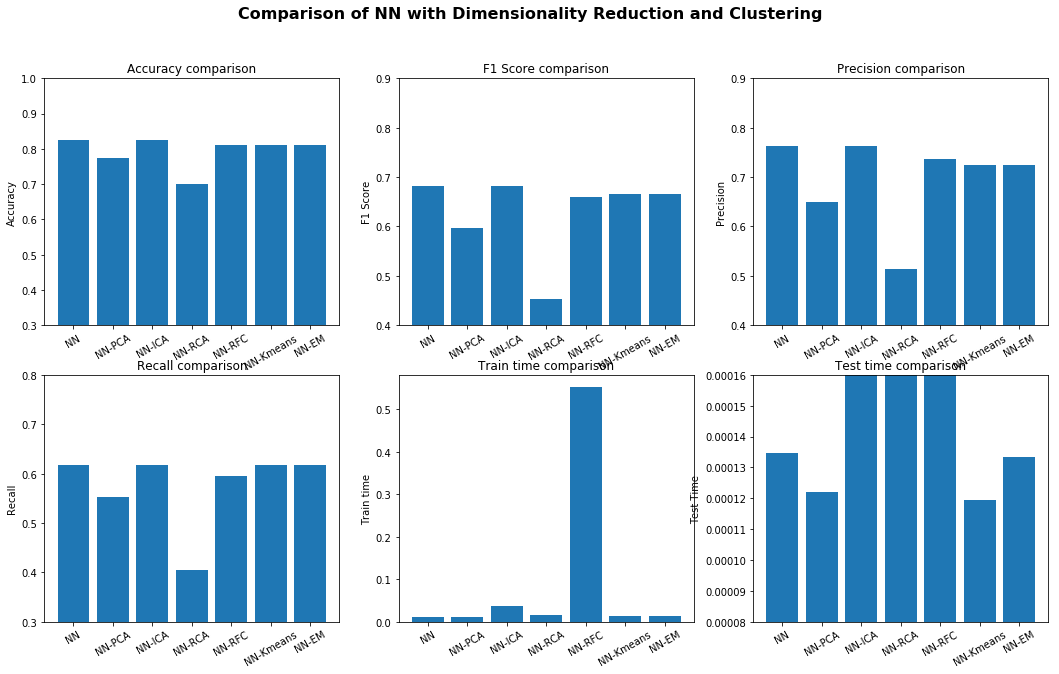

In [145]:
plt.figure(figsize=(18, 10))
w=0.8
#plt.figure()
plt.subplot(231)
# ax = plt.subplot(231)
# ax.bar(x_label-w, accuracy, width=w, label = "Accuracy")
# ax.bar(x_label, f1, width=w, color = '#73C2FB', label = "F1")
# ax.set_xticks(x_label - w/2)
# ax.legend()
plt.suptitle('Comparison of NN with Dimensionality Reduction and Clustering', fontsize=16, fontweight='bold')
plt.bar(x_label, accuracy, w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
plt.gca().set_ylim(0.3, 1)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')

plt.subplot(232)
plt.bar(x_label, f1, w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
plt.gca().set_ylim(0.4, 0.9)
plt.title('F1 Score comparison')
plt.ylabel('F1 Score')

plt.subplot(233)
plt.bar(x_label, precision,w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
plt.gca().set_ylim(0.4, 0.9)
plt.title('Precision comparison')
plt.ylabel('Precision')

plt.subplot(234)
plt.bar(x_label, recall, w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
plt.gca().set_ylim(0.3, 0.8)
plt.title('Recall comparison')
plt.ylabel('Recall')

plt.subplot(235)
plt.bar(x_label, training_time,w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
plt.title('Train time comparison')
plt.ylabel('Train time')

plt.subplot(236)
plt.bar(x_label, pred_time,w)
plt.gca().set_xticks(x_label)
plt.gca().set_xticklabels(classifiers, rotation =30)
plt.gca().set_ylim(0.00008, 0.00016)
plt.title('Test time comparison')
plt.ylabel('Test Time')

plt.show()

